# Anticipez les besoins en consommation électrique de bâtiments

**Problématique de la ville de Seattle**  
Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

**Votre mission**  
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Faire bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mettre en place une évaluation rigoureuse des performances de la régression, et optimiser les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

**Livrables attendus**  
- Un notebook de l'analyse exploratoire mis au propre et annoté.
- Le code (ou un notebook) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
- Un support de présentation pour la soutenance.

**Compétences évaluées**  
- Mettre en place le modèle d'apprentissage supervisé adapté au problème métier
- Évaluer les performances d’un modèle d'apprentissage supervisé
- Adapter les hyperparamètres d'un algorithme d'apprentissage supervisé afin de l'améliorer
- Transformer les variables pertinentes d'un modèle d'apprentissage supervisé

__Techniques__
- ACP: réduction de dimension
- clustering hiérarchique
- knn


# Sommaire

__[I. Chargement et nettoyage des données](#I.-Chargement-et-nettoyage-des-données)__\
[I.1 Descriptions des indicateurs](#I.1-Descriptions-des-indicateurs)\
[I.2 Sélection des variables](#I.2-Sélection-des-variables)

__[II. Analyse exploratoire](#II.-Analyse-exploratoire)__\
[II.1 Variables qualitatives et variables quantitatives](#II.1-Variables-qualitatives-et-variables-quantitatives)\
[II.2 Variables quantitatives](#II.2-Variables-quantitatives)\
[II.2.1 Distribution des variables quantitatives](#II.2.1-Distribution-des-variables-quantitatives)\
[II.2.2 outliers](#II.2.2-outliers)\
[II.2.3 Transformation des variables cibles](#II.2.3-Transformation-des-variables-cibles)\
[II.2.4 Etude des corrélations](#II.2.4-Etude-des-corrélations)\
[II.2.4.i Variables cibles](#II.2.4.i-Variables-cibles)\
[II.2.4.ii Prédicteurs](#II.2.4.ii-Prédicteurs)\
[II.3 Variables catégorielles](#II.3-Variables-catégorielles)\
[II.3.1 Nettoyage des variables catégorielles](#II.3.1-Nettoyage-des-variables-catégorielles)\
[II.3.2 Etude des corrélations](#II.3.2-Etude-des-corrélations)

__[III Modèles Linéaires](#III-Modèles-Linéaires)__\
[III.1 Régression linéaire simple avec toutes les variables](#III.1-Régression-linéaire-simple-avec-toutes-les-variables)\
[III.3 Ridge](#III.3-Ridge)\
[III.4 Lasso](#III.4-Lasso)\
[III.5 ElasticNet](#III.5-ElasticNet)

__[IV kNN](#IV-kNN)__

__[V SVM](#V-SVM)__

__[VI Modèles non-linéaires](#VI-Modèles-non-linéaires)__\
[VI.1 SVM à noyau](#VI.1-SVM-à-noyau)

__[VII Méthodes ensemblistes](#VII-Méthodes-ensemblistes)__\
[VII.1 Forêts aléatoires](#VII.1-Forêts-aléatoires)\
[VII.2 GradientBoostingRegressor](#VII.2-GradientBoostingRegressor)

__[VIII Choix du modèle](#VIII-Choix-du-modèle)__

__[A suivre: Latitude, Longitude](#A-suivre:-Latitude,-Longitude)__

In [1805]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# I. Chargement et nettoyage des données

## I.1 Descriptions des indicateurs

1er dataset: 2015-building-energy-benchmarking.csv

In [1806]:
data2015 = pd.read_csv("./data/2015-building-energy-benchmarking.csv")
data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [1807]:
indicators = pd.Series(data2015.columns, name="indicators")
indicators

0                                         OSEBuildingID
1                                              DataYear
2                                          BuildingType
3                                   PrimaryPropertyType
4                                          PropertyName
5                         TaxParcelIdentificationNumber
6                                              Location
7                                   CouncilDistrictCode
8                                          Neighborhood
9                                             YearBuilt
10                                    NumberofBuildings
11                                       NumberofFloors
12                                     PropertyGFATotal
13                                   PropertyGFAParking
14                               PropertyGFABuilding(s)
15                            ListOfAllPropertyUseTypes
16                               LargestPropertyUseType
17                            LargestPropertyUse

2eme dataset: 2016-building-energy-benchmarking

In [1808]:
data2016 = pd.read_csv("./data/2016-building-energy-benchmarking.csv")
indicators_2016 = pd.Series(data2016.columns, name="indicators_2016")
indicators_2016

0                       OSEBuildingID
1                            DataYear
2                        BuildingType
3                 PrimaryPropertyType
4                        PropertyName
5                             Address
6                                City
7                               State
8                             ZipCode
9       TaxParcelIdentificationNumber
10                CouncilDistrictCode
11                       Neighborhood
12                           Latitude
13                          Longitude
14                          YearBuilt
15                  NumberofBuildings
16                     NumberofFloors
17                   PropertyGFATotal
18                 PropertyGFAParking
19             PropertyGFABuilding(s)
20          ListOfAllPropertyUseTypes
21             LargestPropertyUseType
22          LargestPropertyUseTypeGFA
23       SecondLargestPropertyUseType
24    SecondLargestPropertyUseTypeGFA
25        ThirdLargestPropertyUseType
26     Third

Indicateurs qui ne sont pas en commun entre les deux datasets?

In [1809]:
set(indicators_2016.to_numpy()).difference(indicators.to_numpy())

{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

In [1810]:
set(indicators.to_numpy()).difference(set(indicators_2016.to_numpy()))

{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

#### Indicateurs 2015-building-energy-benchmarking

name | description 
--- | --- |
OSEBuildingID|A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
"BuildingType"|"City of Seattle building type classification."
PrimaryPropertyType|The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
PropertyName|Official or common property name.
TaxParcelIdentificationNumber|Property King County PIN
CouncilDistrictCode|Property City of Seattle council district.
YearBuilt|Year in which a property was constructed or underwent a complete renovation.
PropertyGFATotal|Total building and parking gross floor area.
PropertyGFAParking|Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).
PropertyGFABuilding(s)|Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.
ENERGYSTARScore|An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.
SiteEUI(kBtu/sf)|Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.
SiteEUIWN(kBtu/sf)|Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
SourceEUI(kBtu/sf)|Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.
SourceEUIWN(kBtu/sf)|Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
SiteEnergyUse(kBtu)|The annual amount of energy consumed by the property from all sources of energy.
SteamUse(kBtu)|The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).
Electricity(kWh)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh.
Electricity(kBtu)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).
NaturalGas(therms)|The annual amount of utility-supplied natural gas consumed by the property, measured in therms.
GHGEmissions(MetricTonsCO2e)|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.
GHGEmissionsIntensity(kgCO2e/ft2)|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources



#### Indicateurs 2016-building-energy-benchmarking

name | description 
--- | --- |
TotalGHGEmissions|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.
GHGEmissionsIntensity|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

Indicateur Location dans la table 2015 absent de la table 2016, en revanche les indicateurs Latitude, Longitude, Address, City, State et Zipcode sont absents de la table 2015 et présents dans 2016.

In [1811]:
data2015.Location.iloc[0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

Il semblerait que les colonnes Latitude Longitude Address City State ZipCode soient contenues dans Location

Dans la table 2015, les valeurs de Zip Codes semble être générés automatiquement - on l'écarte du jeu de données

In [1812]:
data2015.drop(columns="Zip Codes", inplace=True)

On va donc, dans la table 2015: 
- splitter Location en Latitude, Longitude, Address City State ZipCode
- Retirer Zip Codes

Renommer certaines colonnes pour assurer la correspondance avec 2016, de façon à fusionner les tables
- GHGEmissions(MetricTonsCO2e) (2015) et TotalGHGEmissions (2016) sont en fait les mêmes colonnes
- GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity sont les mêmes colonnes

**1. Split**

In [1813]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant

data2015["Location"] = data2015["Location"].apply(literal_eval) # convertit les str en dict
df = pd.json_normalize(data2015["Location"]) # Normalize semi-structured JSON data into a flat table.
df.human_address = df.human_address.apply(literal_eval)
df2 = pd.json_normalize(df.human_address)
df2.head()

,address,city,state,zip
0,405 OLIVE WAY,SEATTLE,WA,98101
1,724 PINE ST,SEATTLE,WA,98101
2,1900 5TH AVE,SEATTLE,WA,98101
3,620 STEWART ST,SEATTLE,WA,98101
4,401 LENORA ST,SEATTLE,WA,98121


In [1814]:
loc = data2015.columns.get_loc("Location")
data2015.drop(columns="Location", inplace=True)
d = pd.concat([df.drop(columns="human_address"), df2], axis=1) # nouveau dataframe à partir des colonnes extraites

for c in d.columns[::-1]: # Insertion des colonnes dans le df original, une par une
    data2015.insert(loc, c, d[c])

data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,latitude,longitude,address,city,...,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


**2. Renommage**

In [1815]:
data2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                         "Comment":"Comments",
                         "latitude":"Latitude", 
                         "longitude":"Longitude", 
                         "address":"Address", 
                         "city":"City",
                         "state":"State"}, inplace=True)

data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Latitude,Longitude,Address,City,...,TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


Fusion des deux datasets en un dataset global

In [1816]:
# création du dataset global
raw_data = pd.concat([data2015, data2016], join="outer")

# Récupération de la liste de colonnes sous forme de Series
raw_data_cols = pd.Series(raw_data.columns, name="data_cols")

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 52 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  6716 non-null   int64  
 1   DataYear                                                       6716 non-null   int64  
 2   BuildingType                                                   6716 non-null   object 
 3   PrimaryPropertyType                                            6716 non-null   object 
 4   PropertyName                                                   6716 non-null   object 
 5   TaxParcelIdentificationNumber                                  6714 non-null   object 
 6   Latitude                                                       6716 non-null   object 
 7   Longitude                                                   

## I.2 Sélection des variables

On effectue un premier tri des variables, en écartant d'emblée celles qui semblent le moins pertinentes.

<AxesSubplot:>

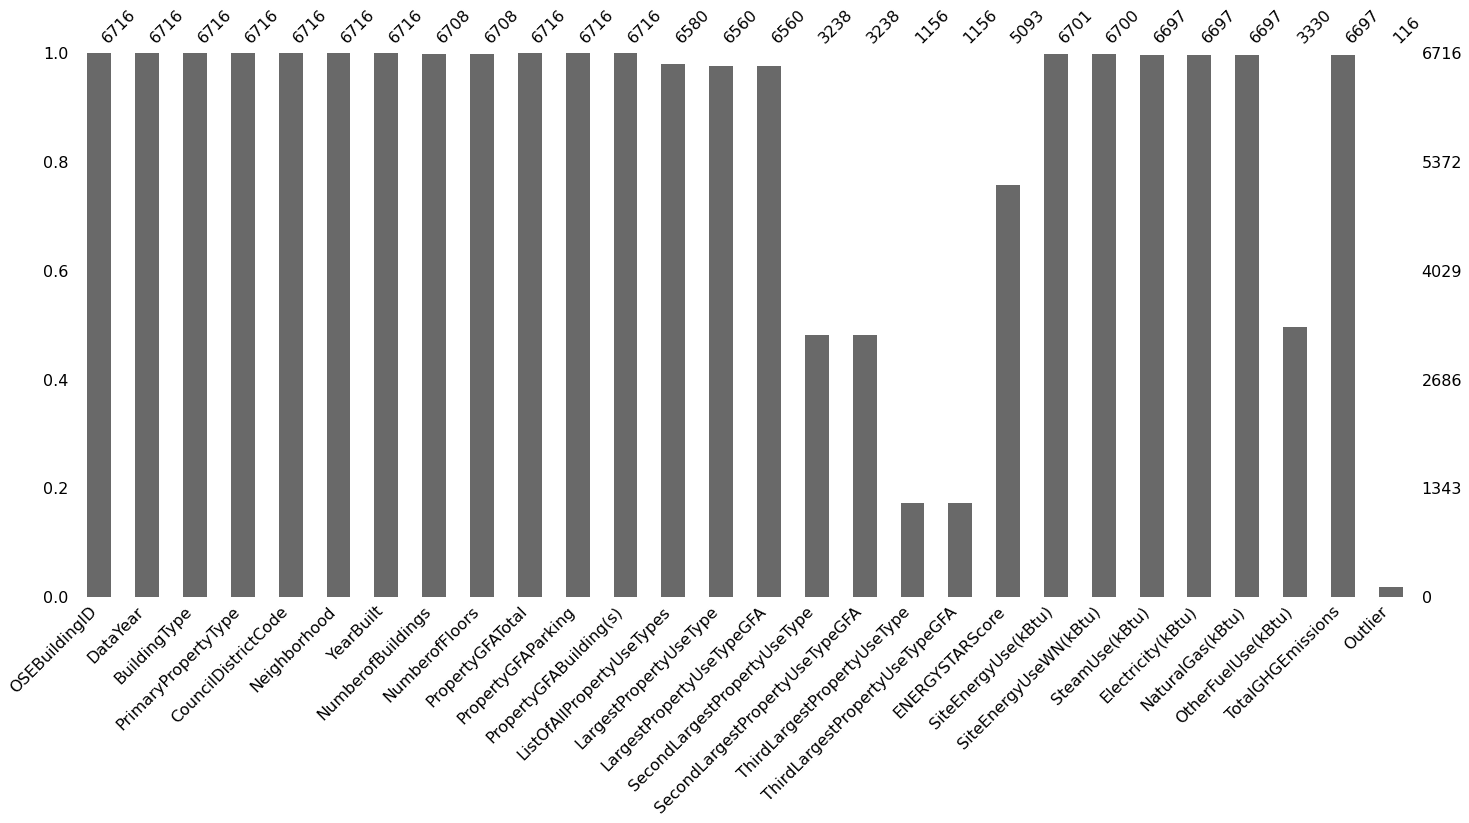

In [1817]:
to_drop_index = [*range(4, 12), # PropertyName, TaxParcelIdentificationNumber --> zip
                 27, # YearsENERGYSTARCertified
                 *range(29, 33), # SiteEUI, SourceEUI, SiteEUIWN, SourceEUIWN
                 36, # Electricity (kWh)
                 38, # NaturalGas (therms)
                 *range(42, 46), # GHGEmissionIntensity, DefaultData, Comments, ComplianceStatus
                 *range(47,52)] # 2010 Census Tracts, Seattle Police..., City Council, SPD Beats, ZipCode
to_drop_cols = raw_data_cols.iloc[to_drop_index]
raw_data = raw_data.drop(columns=to_drop_cols)

msno.bar(raw_data)

Toutes les variables sont quasiment ou totalement remplies, à l'exception de SecondLargestPropertyUseType, ThirdLargestPropertyUseType, SecondLargest\[...\]GFA, ThirdLargest\[...\]GFA. On inspecte ces variables, qui semblent appartenir à des couples (catégorielle, quantitative).

**ListofAllPropertyUseTypes, LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType**

In [1818]:
raw_data[["ListOfAllPropertyUseTypes",
          "LargestPropertyUseType",
          "SecondLargestPropertyUseType", 
          "ThirdLargestPropertyUseType"]].sample(15)

,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
1873,Multifamily Housing,Multifamily Housing,NaN,NaN
3002,Multifamily Housing,Multifamily Housing,NaN,NaN
1649,Multifamily Housing,Multifamily Housing,NaN,NaN
3019,"Other - Services, Retail Store",Other - Services,Retail Store,NaN
1935,Multifamily Housing,Multifamily Housing,NaN,NaN
1835,"Multifamily Housing, Retail Store",Multifamily Housing,Retail Store,NaN
208,"Office, Retail Store",Office,Retail Store,NaN
169,"Non-Refrigerated Warehouse, Parking",Non-Refrigerated Warehouse,Parking,NaN
61,"Hotel, Parking",Hotel,Parking,NaN
842,"Multifamily Housing, Parking",Multifamily Housing,Parking,NaN


**Dans les variables catégorielles, on remplace NaN par "None". Sur les variables quantitatives associées, on va remplacer les NaN par 0**

In [1819]:
raw_data["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
raw_data["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
raw_data["SecondLargestPropertyUseType"].fillna("None", inplace=True)
raw_data["ThirdLargestPropertyUseType"].fillna("None", inplace=True)

**OtherFuelUse(kBtu)**

In [1820]:
raw_data["OtherFuelUse(kBtu)"].describe()

count    3.330000e+03
mean     7.142301e+03
std      1.962790e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.269669e+06
Name: OtherFuelUse(kBtu), dtype: float64

<AxesSubplot:xlabel='OtherFuelUse(kBtu)', ylabel='Count'>

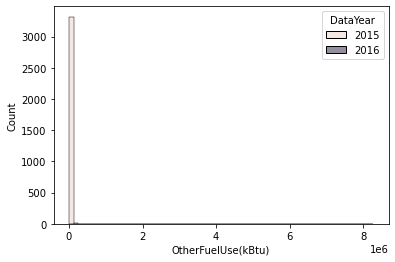

In [1821]:
sns.histplot(data=raw_data, x="OtherFuelUse(kBtu)", hue="DataYear", bins=int(1+5*np.log2(raw_data.shape[0])))

In [1822]:
print(raw_data["OtherFuelUse(kBtu)"].quantile(0.994))
print(raw_data["OtherFuelUse(kBtu)"].quantile(0.995))

0.0
194.18500000000995


Cette colonne ne contient pratiquement que des valeurs nulles. On la supprime.

<AxesSubplot:>

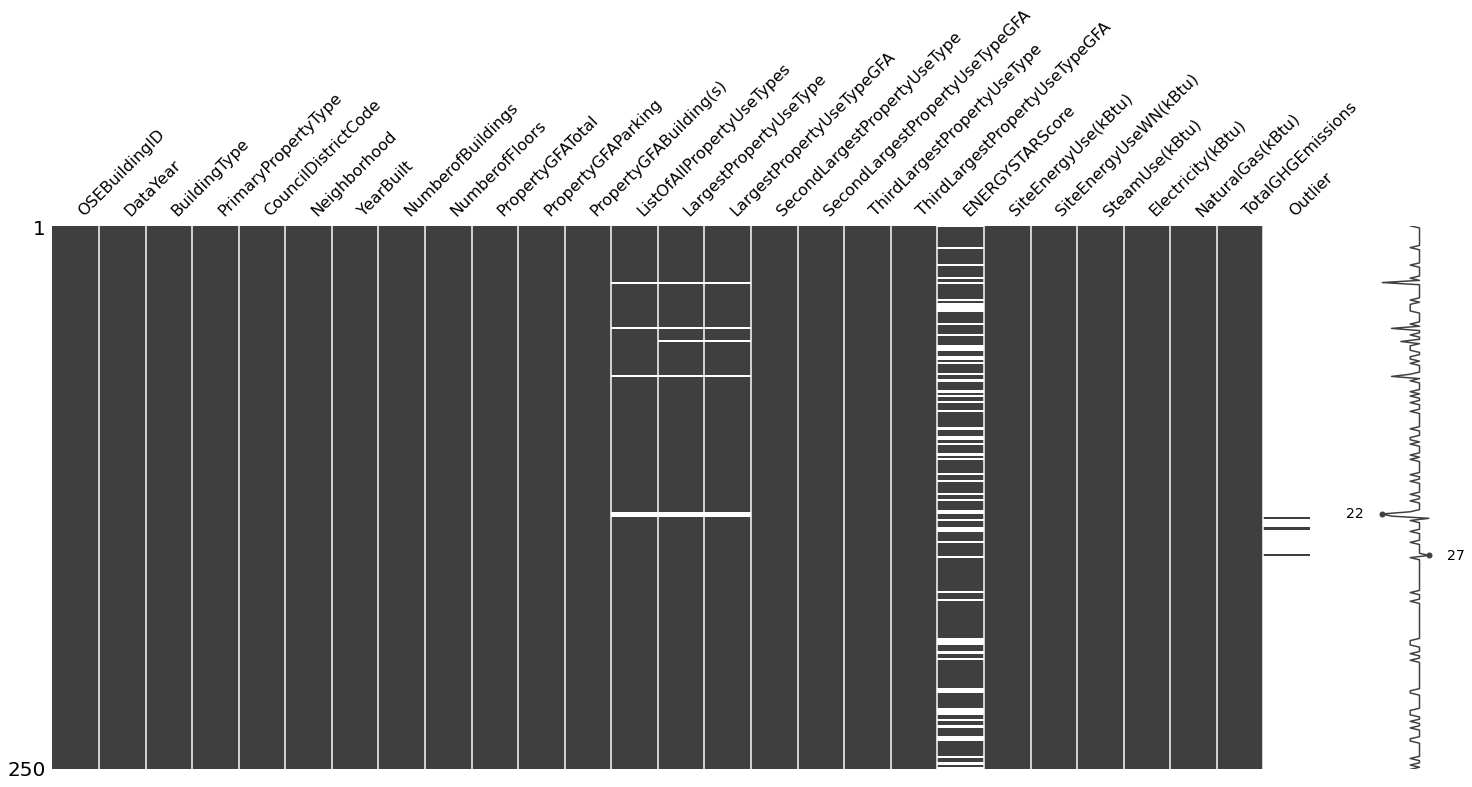

In [1823]:
raw_data.drop(columns='OtherFuelUse(kBtu)', inplace=True)
msno.matrix(raw_data.sample(250))

On supprime les lignes contenant des valeurs manquantes.

<AxesSubplot:>

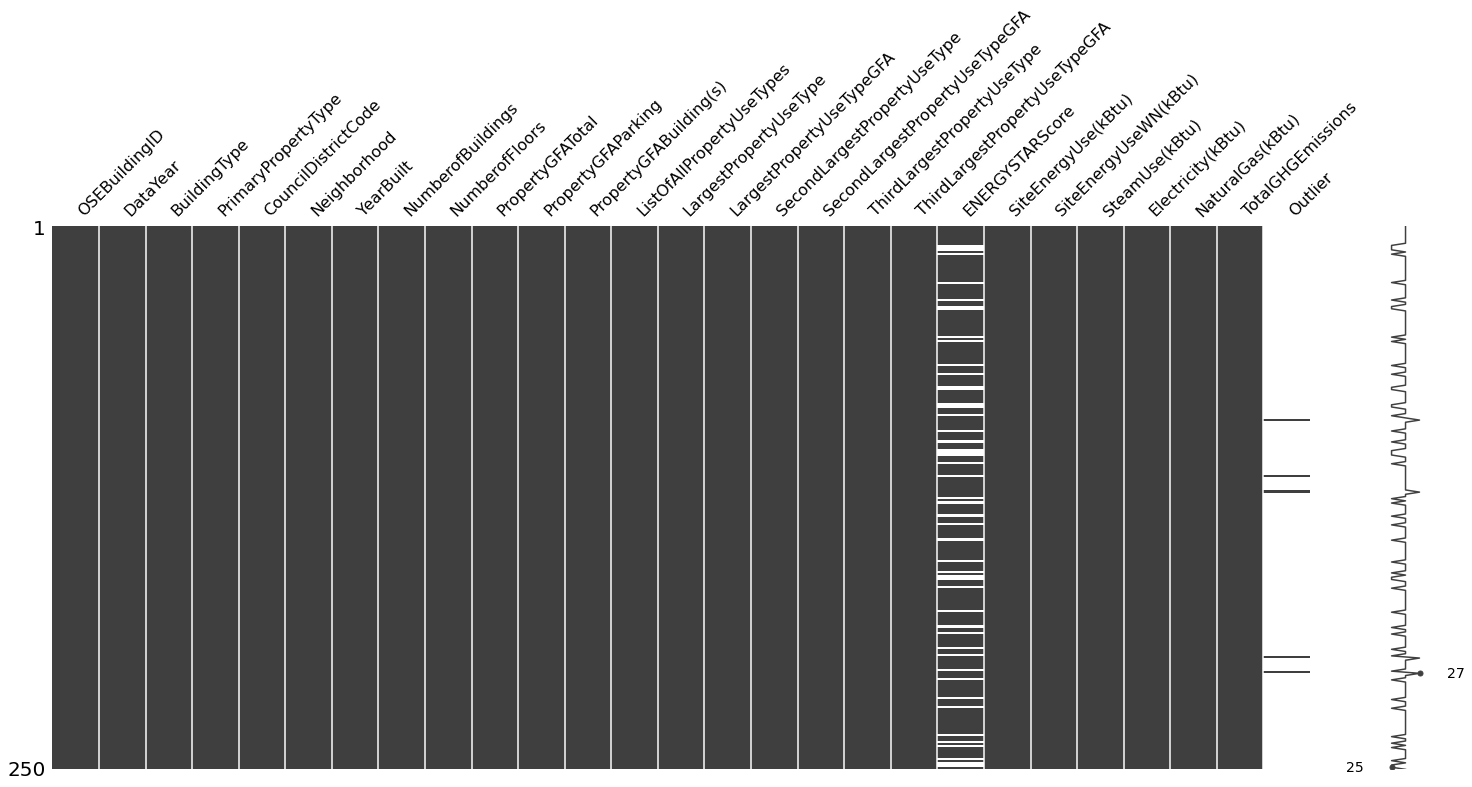

In [1824]:
raw_data.dropna(subset=["ListOfAllPropertyUseTypes"], inplace=True)
raw_data.dropna(subset=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], how="any", inplace=True)
raw_data.dropna(subset=["LargestPropertyUseType"],inplace=True)
raw_data.dropna(subset=["NumberofBuildings", "NumberofFloors"], how="any", inplace=True)
msno.matrix(raw_data.sample(250))

<AxesSubplot:>

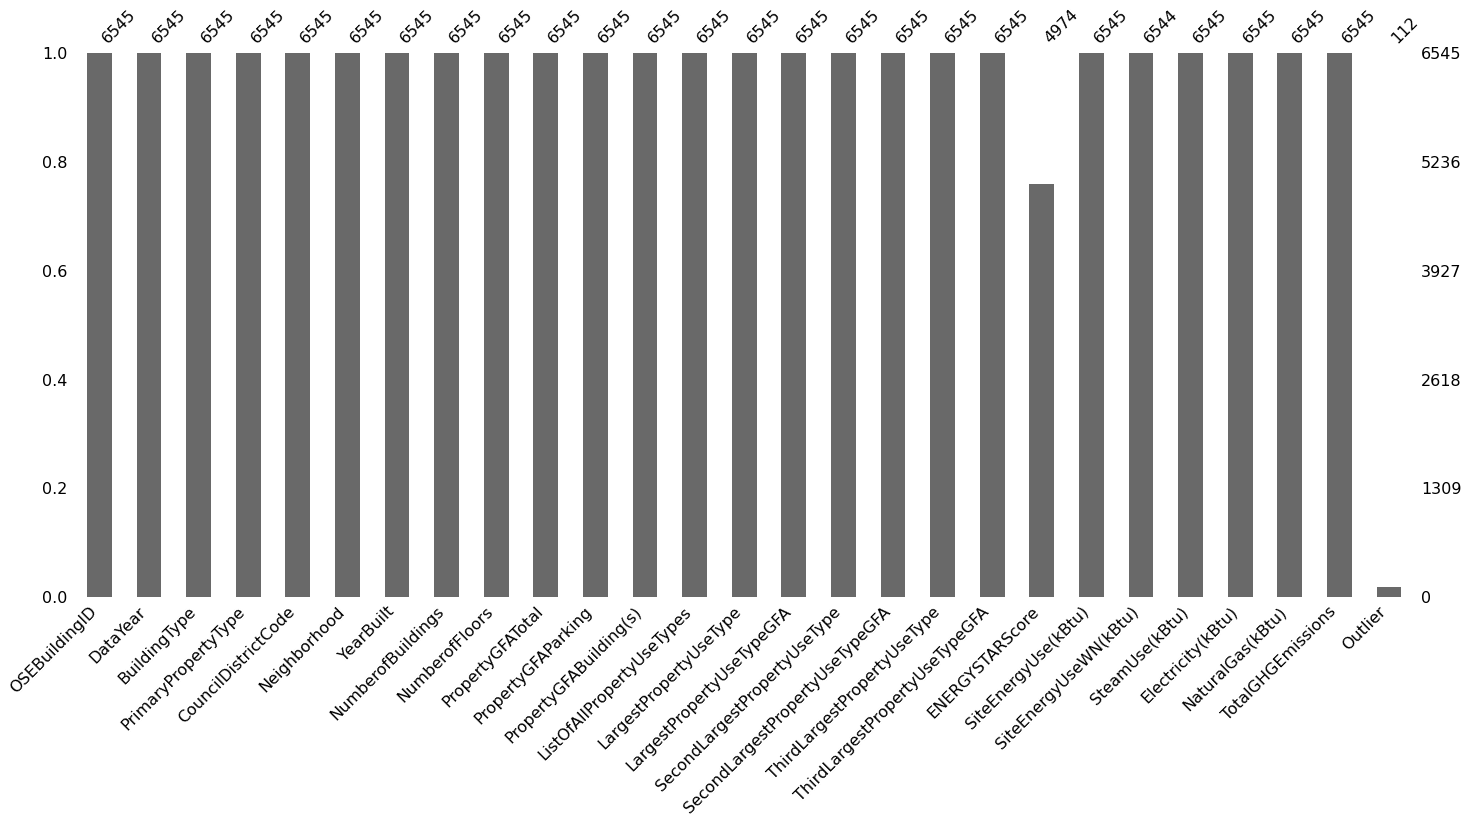

In [1825]:
raw_data.to_csv("raw_data2.csv", index_label=False)
msno.bar(raw_data)

# II. Analyse exploratoire

In [1826]:
raw_data = pd.read_csv("./raw_data2.csv")

## II.1 Variables qualitatives et variables quantitatives

In [1827]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6545 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6545 non-null   int64  
 1   DataYear                         6545 non-null   int64  
 2   BuildingType                     6545 non-null   object 
 3   PrimaryPropertyType              6545 non-null   object 
 4   CouncilDistrictCode              6545 non-null   int64  
 5   Neighborhood                     6545 non-null   object 
 6   YearBuilt                        6545 non-null   int64  
 7   NumberofBuildings                6545 non-null   float64
 8   NumberofFloors                   6545 non-null   float64
 9   PropertyGFATotal                 6545 non-null   int64  
 10  PropertyGFAParking               6545 non-null   int64  
 11  PropertyGFABuilding(s)           6545 non-null   int64  
 12  ListOfAllPropertyUse

**On sépare le dataframe en deux: les colonnes numériques et les colonnes "object"**

In [1828]:
mask = raw_data.dtypes!="object"
numerical_features = mask[mask].index
numerical_features

Index(['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

In [1829]:
mask = raw_data.dtypes=="object"
categorical_features = mask[mask].index
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Outlier'],
      dtype='object')

**On retire les colonnes OSEBuildingID, DataYear, YearBuilt, qui sont des variables catégorielles en réalité**

In [1830]:
num_categorical = pd.Index(["OSEBuildingID", 
                            "DataYear",
                            "YearBuilt", 
                            "CouncilDistrictCode"
                           ])

In [1831]:
# On récupère ces colonnes dans la liste des indicateurs catégoriels
categorical_features = categorical_features.append(num_categorical)
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Outlier', 'OSEBuildingID', 'DataYear', 'YearBuilt',
       'CouncilDistrictCode'],
      dtype='object')

In [1832]:
# On crée l'index quantitative_features qui ne contient que les variables quantitatives
quantitative_features = pd.Index([c for c in numerical_features if c not in categorical_features])
quantitative_features

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

## II.2 Variables quantitatives

On souhaite se passer des relevés annuels. On doit donc arriver à faire des prédictions sur les variables "targets" sans les variables "SiteEUI, SiteEUIWN, SourceEUI, SourceEUIWN, SiteEnergyUseWN, SteamUse, Electricity, NaturalGas, GHGEmissionsIntensity".

In [1833]:
# On exclut les indicateurs liés à l'énergie consommée dans la liste des indicateurs quantitatifs
#quantitative_features = pd.Index(['NumberofBuildings',
#                    'NumberofFloors', 
#                    'PropertyGFATotal',
#                    'PropertyGFAParking',
#                    'PropertyGFABuilding(s)',
#                    'LargestPropertyUseTypeGFA'])
targets = pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])

### II.2.1 Distribution des variables quantitatives

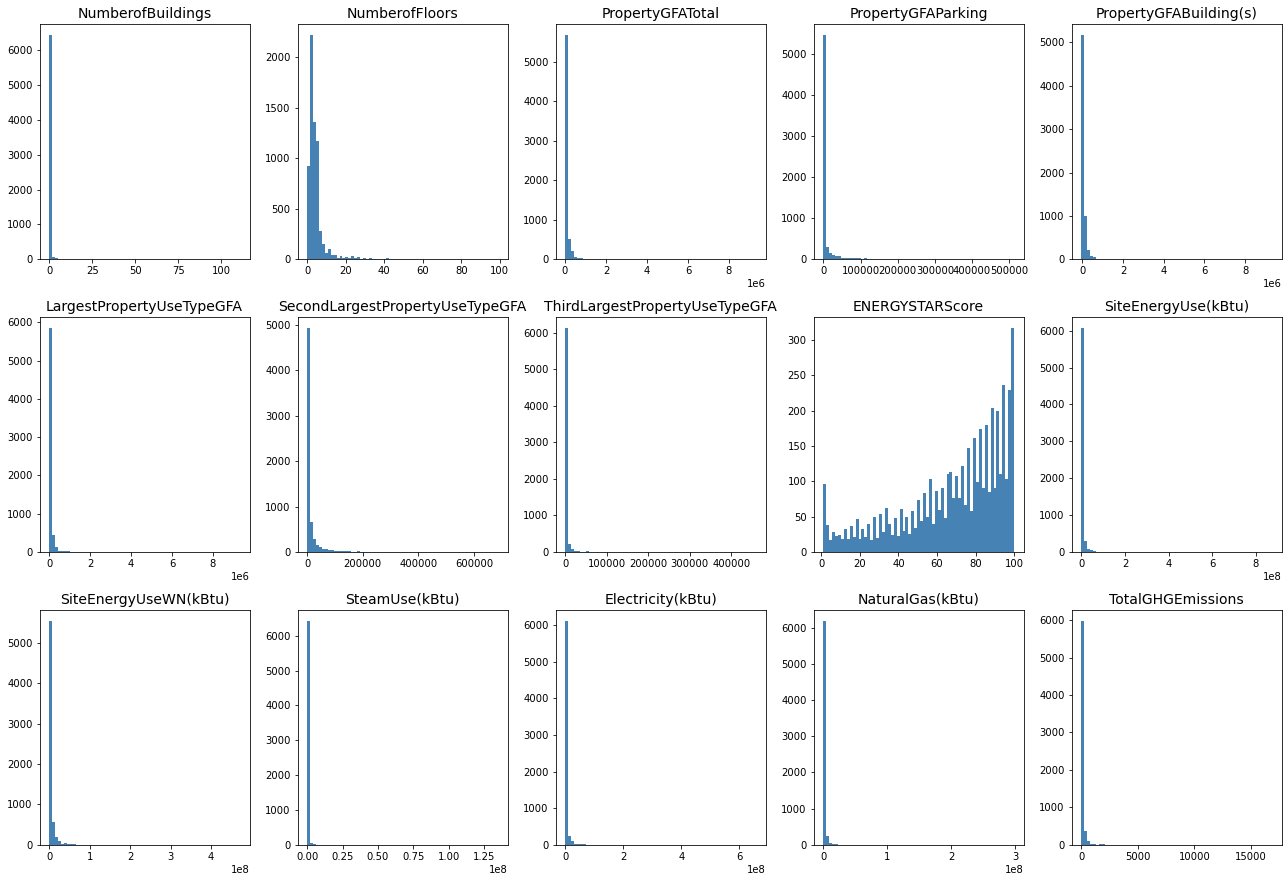

In [1834]:
fig = plt.figure(figsize=(18, 16))
for feat_idx, feat in enumerate(quantitative_features):
    ax = fig.add_subplot(4,5, (feat_idx+1))
    h = ax.hist(raw_data[feat], bins=5*int(1+np.log2(raw_data.shape[0])), color = 'steelblue', density=False, edgecolor='none')
    ax.set_title(feat, fontsize=14)
    plt.tight_layout()

Données très dispersées. Echelles très différentes d'une variable à l'autre. On a des outliers. On a également des valeurs à 0 (NumberofBuildings, TotalGHGEmission, LargestPropertyUseTypeGFA etc.) Surement des valeurs aberrantes.  On vérifie.

In [1835]:
for feat in quantitative_features:
    print(raw_data[feat].describe(percentiles=[0.5]))
    print("-"*40)

count    6545.000000
mean        1.069824
std         1.606027
min         0.000000
50%         1.000000
max       111.000000
Name: NumberofBuildings, dtype: float64
----------------------------------------
count    6545.000000
mean        4.695951
std         5.478857
min         0.000000
50%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64
----------------------------------------
count    6.545000e+03
mean     9.282417e+04
std      1.889431e+05
min      1.128500e+04
50%      4.400000e+04
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64
----------------------------------------
count      6545.000000
mean       9499.640947
std       33953.785159
min          -3.000000
50%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64
----------------------------------------
count    6.545000e+03
mean     8.332453e+04
std      1.748017e+05
min     -5.055000e+04
50%      4.218200e+04
max      9.320156e+06
Name: PropertyGFABuilding

Confirmation de l'observation précédente: valeurs aberrantes (surfaces négatives), très dispersées (std >= moyenne), présence probable d'outliers (max >> {moyenne, mediane}). Distribution non-normales.

### II.2.2 outliers

On utilise la colonne "Outlier"

In [1836]:
raw_data["Outlier"].head()

0             NaN
1             NaN
2             NaN
3    High Outlier
4             NaN
Name: Outlier, dtype: object

In [1837]:
raw_data["Outlier"].unique()

array([nan, 'High Outlier', 'Low Outlier', 'High outlier', 'Low outlier'],
      dtype=object)

In [1838]:
# On regroupe les outliers dans la catégorie "Yes", et les valeurs NaN dans "No"
outlier_yn = raw_data["Outlier"].where(raw_data["Outlier"].notna(), "No")
raw_data["Outlier_yn"] = outlier_yn
raw_data["Outlier_yn"] = raw_data["Outlier_yn"].apply(lambda x: "Yes" if x!="No" else x)

# On exclut les outliers
raw_data = raw_data.loc[raw_data.Outlier_yn=="No"]

# On supprime les colonnes "Outlier" et "Outlier_yn"
raw_data.drop(columns=["Outlier", "Outlier_yn"], inplace=True)

# On supprime également cette variables de la liste categorical_features
categorical_features = categorical_features.drop(["Outlier"])

In [1839]:
# On corrige les valeurs négatives de PropertyGFABuilding(s)
m = raw_data["PropertyGFABuilding(s)"] <= 0
raw_data["PropertyGFABuilding(s)"].mask(m, -raw_data["PropertyGFABuilding(s)"], inplace=True)

# On retire les valeurs de TotalGHGEmissions, NumberofBuildings qui sont négatives ou nulles, et
# les valeurs de SiteEnergyUse(kBtu) qui sont nulles (nécessaire pour prendre le logarithme des variables
# cibles en vue des prédictions)
d = raw_data.query("TotalGHGEmissions<=0 or NumberofBuildings<=0 or `SiteEnergyUse(kBtu)`==0").index
raw_data.drop(index=d, inplace=True)

# Il y a un bâtiment de 99 étages dont les émissions sont quasi-nulles: on l'écarte, il s'agit certainement
# d'un outlier.
raw_data = raw_data[raw_data.NumberofFloors<80] 

In [1840]:
# Reindexation du dataframe
raw_data.index = pd.Index(range(0, raw_data.shape[0]))

raw_data.to_csv("./data.csv", index_label=False)
data = raw_data

## II.2.3 Transformation des variables cibles

On remplace les variables targets par leur log.

In [1841]:
data = pd.read_csv("./data.csv")

In [1842]:
data["SiteEnergyUse_log"] = data["SiteEnergyUse(kBtu)"].apply(np.log10)
data["TotalGHGEmissions_log"] = data["TotalGHGEmissions"].apply(np.log10)
targets = pd.Index(["SiteEnergyUse_log", "TotalGHGEmissions_log"])
quantitative_features = quantitative_features.append(pd.Index(["SiteEnergyUse_log", "TotalGHGEmissions_log"]))

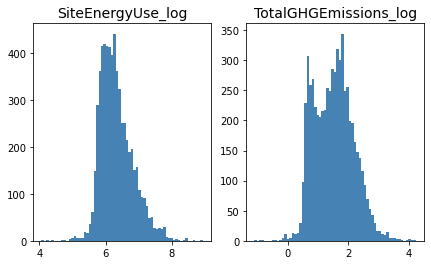

In [1843]:
fig = plt.figure(figsize=(7, 4))
for feat_idx, feat in enumerate(targets):
    ax = fig.add_subplot(1,2, (feat_idx+1))
    h = ax.hist(data[feat], bins=5*int(1+np.log2(data.shape[0])), color = 'steelblue', density=False, edgecolor='none')
    ax.set_title(feat, fontsize=14)

Distribution clairement bi-modale pour TotalGHGEmissions

## II.2.4 Etude des corrélations

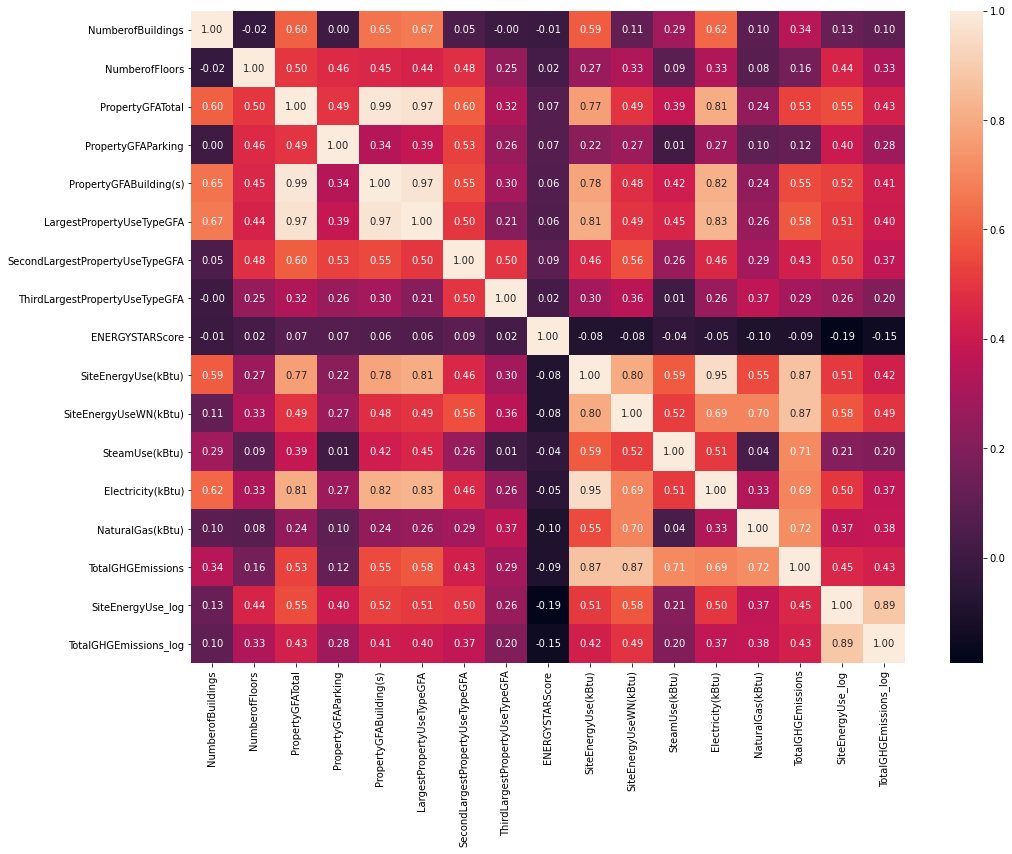

In [1844]:
corr = data[quantitative_features].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

Globalement, corrélations plus fortes avec les cibles  qu'avec les log des cibles. Les log des cibles sont plus fortement corrélées (linéairement) entre eux que les cibles elles-mêmes.
Enfin, SiteEnergyUse plus fortement corrélée avec les autres variables que TotalGHGEmissions: on va d'abord chercher à prédire SiteEnergyUse, puis on va chercher à prédire TotalGHGEmissions à partir de cette prédiction.

#### II.2.4.i Variables cibles

In [1845]:
feats = ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]
feats_log = ["TotalGHGEmissions_log", "SiteEnergyUse_log"]

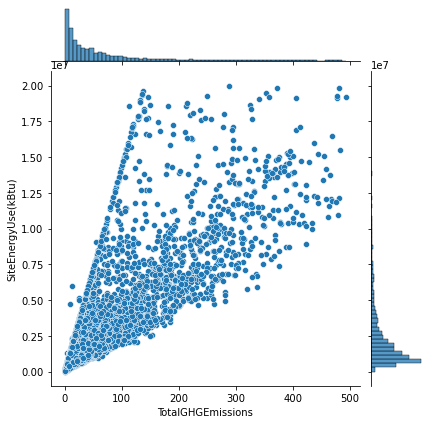

In [1846]:
# jointplot sans les outliers pour une meilleure visualisation
sns.jointplot(data=data.query("TotalGHGEmissions<500 and `SiteEnergyUse(kBtu)`<2e7"), x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)")
plt.show()

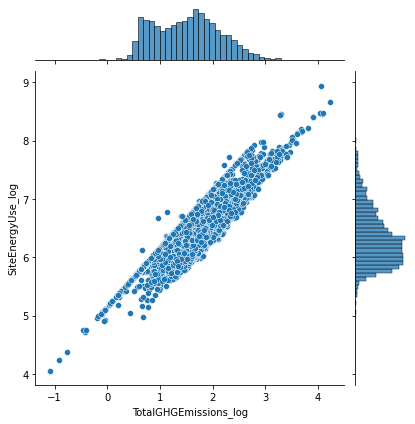

In [1847]:
sns.jointplot(data=data, x="TotalGHGEmissions_log", y="SiteEnergyUse_log")
plt.show()

#### II.2.4.ii Prédicteurs

On a de fortes corrélations entre les variables "PropertyGFATotal", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA".

PropertyGFATotal somme de PropertyGFAParking et PropertyGFABuilding(s) ?

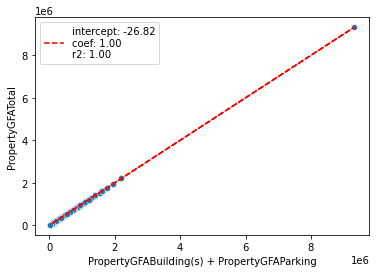

In [1848]:
sum_pgfa = data.loc[:, ["PropertyGFABuilding(s)", "PropertyGFAParking"]].apply(np.sum, axis=1)
tot_pgfa = data.PropertyGFATotal

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = sum_pgfa.to_numpy().reshape(-1, 1)
y = tot_pgfa.to_numpy()

lr.fit(X, y)
r2 = lr.score(X, y)
sns.scatterplot(x=sum_pgfa, y=tot_pgfa)
plt.plot(sum_pgfa, lr.intercept_ + sum_pgfa*lr.coef_, linestyle="--", color="r", label="intercept: {:.2f}\ncoef: {:.2f}\nr2: {:.2f}".format(lr.intercept_, lr.coef_[0], r2))
plt.legend()
plt.xlabel("PropertyGFABuilding(s) + PropertyGFAParking")
plt.show()

$\rightarrow$ On n'utilisera pas PropertyGFATotal. PropertyBuilding(s) vs LargestPropertyUseTypeGFA:

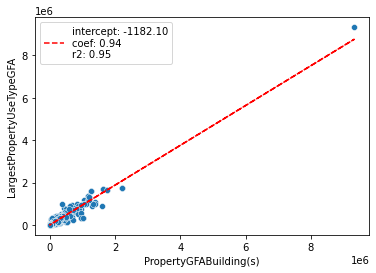

In [1849]:
X = data["PropertyGFABuilding(s)"].to_numpy().reshape(-1, 1)
y = data["LargestPropertyUseTypeGFA"]

lr = LinearRegression()
lr.fit(X, y)
r2 = lr.score(X, y)
sns.scatterplot(x="PropertyGFABuilding(s)", y="LargestPropertyUseTypeGFA", data=data)
plt.plot(X, lr.intercept_ + X*lr.coef_, linestyle="--", color="r", label="intercept: {:.2f}\ncoef: {:.2f}\nr2: {:.2f}".format(lr.intercept_, lr.coef_[0], r2))
plt.legend()
plt.show()

* Forte corrélation entre LargestUseTypeGFA et PropertyGFABuilding(s). A traiter et/ou mettre à contribution lors de l'apprentissage.

**Pour la variable NumberofBuildings, on va plutôt afficher les diagrammes en boîte.**

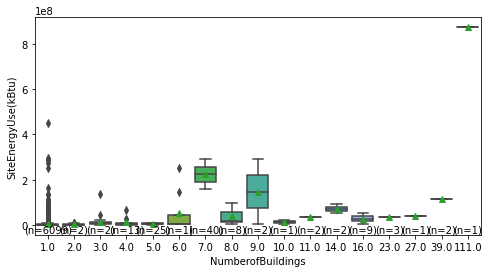

In [1850]:
# affichage des effectifs de chaque classe
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x="NumberofBuildings", y="SiteEnergyUse(kBtu)", data=data, ax=ax, showfliers=True, showmeans=True)
#ax.set_ylim([-0.2e7, 2.2e7])
for pos, g in enumerate(data["NumberofBuildings"].unique()):
    y= data["SiteEnergyUse(kBtu)"].quantile(0.75)
    ax.text(pos, -1e6,"(n={})".format(data[data["NumberofBuildings"]==g].shape[0]),horizontalalignment='center',verticalalignment='top')
plt.show()

Passage au log pour la visualisation

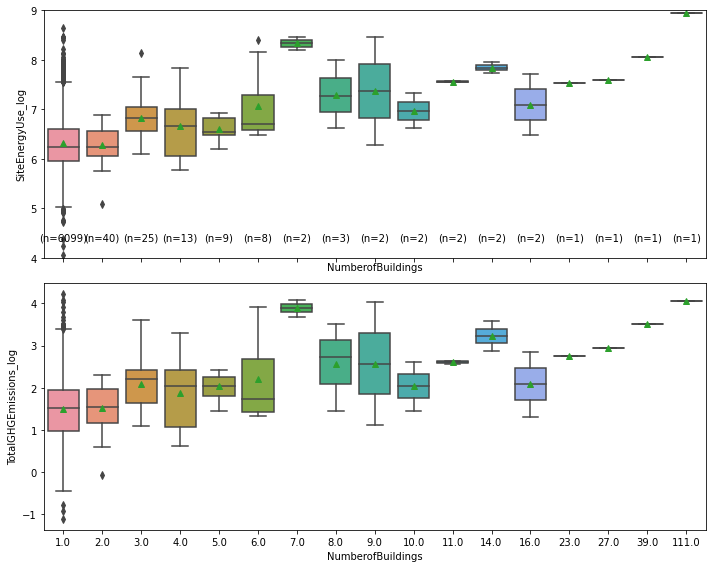

In [1851]:
# affichage des effectifs de chaque classe
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
sns.boxplot(x="NumberofBuildings", y="SiteEnergyUse_log", data=data, ax=ax1, showfliers=True, showmeans=True)
sns.boxplot(x="NumberofBuildings", y="TotalGHGEmissions_log", data=data, ax=ax2, showfliers=True, showmeans=True)
ticks = ax.get_xticks()
ax1.set_ylim([4, 9])
for pos, g in enumerate(sorted(data["NumberofBuildings"].unique())):
    ax1.text(pos, 4.5,"(n={})".format(data[data["NumberofBuildings"]==g].shape[0]),horizontalalignment='center',verticalalignment='top')
plt.tight_layout()
    

Relation linéaire avec les valeurs moyennes de chaque classe (nombre de bâtiment(s)) ?

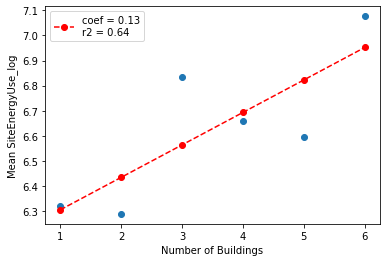

In [1852]:
from matplotlib import ticker

y = data.groupby("NumberofBuildings")["SiteEnergyUse_log"].mean().iloc[[*range(0, 6),
                                                                        #*range(7, 17)
                                                                       ]] # Valeurs moyennes de SiteEnergyUse_log pour chaque classe de NumberofBuildings
X = np.array(sorted(data.NumberofBuildings.unique())).reshape(-1, 1)[[*range(0, 6),
                                                                      #*range(7, 17)
                                                                     ]]# NumberofBuildings
lr = LinearRegression()
lr.fit(X, y.to_numpy())
coef = lr.coef_
inter = lr.intercept_
r2 = lr.score(X, y)
fig, ax = plt.subplots()
ax.plot(X, inter + X*coef, "ro--", label="coef = {:.2f}\nr2 = {:.2f}".format(coef[0], r2))
ax.scatter(X, y)
ax.legend()
ax.set_ylabel("Mean SiteEnergyUse_log")
ax.set_xlabel("Number of Buildings")
ax.xaxis.set_major_locator(ticker.FixedLocator(sorted(data.NumberofBuildings.unique())[:6]))
plt.show()

Il y a clairement une dépendance - en moyenne, la valeur de SiteEnergyUse évolue exponentiellement avec le nombre de bâtiments.

**NumberofFloors**

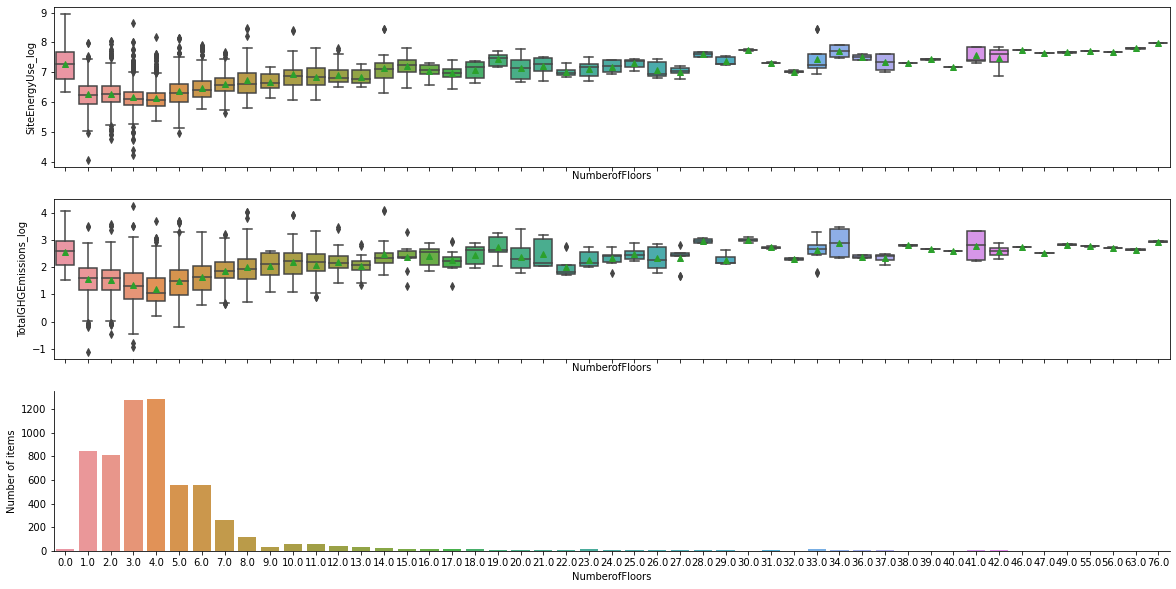

In [1853]:
# affichage des effectifs de chaque classe
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)
sns.boxplot(x="NumberofFloors", y="SiteEnergyUse_log", data=data, ax=ax1, showfliers=True, showmeans=True)
sns.boxplot(x="NumberofFloors", y="TotalGHGEmissions_log", data=data, ax=ax2, showfliers=True, showmeans=True)
sns.countplot(data=data, x="NumberofFloors", ax=ax3)
ax3.set_ylabel("Number of items")
sns.despine(ax=ax3)
plt.show()
#ax.set_ylim([4, 9])
#for pos, g in enumerate(data["NumberofFloors"].unique()):
#    x= data.loc[data["NumberofFloors"]==g, "SiteEnergyUse_log"].quantile(0.75)
#    ax.text(pos, 4.5,"(n={})".format(data[data["NumberofFloors"]==g].shape[0]),horizontalalignment='center',verticalalignment='top')

Ici aussi, claire association entre les deux variables, au moins sur les "premiers" étages. Bâtiments avec 0 étages surement des outliers: on les supprime

In [1854]:
nofloors_index = data[data.NumberofFloors==0].index
data.drop(index=nofloors_index, inplace=True)

## II.3 Variables catégorielles

### II.3.1 Nettoyage des variables catégorielles

On commence par afficher les variables catégorielles ainsi que le nombre de modalités pour chacune d'entre elles.

In [1855]:
cat_feats = pd.DataFrame(data={"nombre de modalités":data[categorical_features].nunique()})
cat_feats

,nombre de modalités
BuildingType,8
PrimaryPropertyType,31
Neighborhood,19
ListOfAllPropertyUseTypes,474
LargestPropertyUseType,57
SecondLargestPropertyUseType,51
ThirdLargestPropertyUseType,43
OSEBuildingID,3332
DataYear,2
YearBuilt,113


Création d'une fonction permettant l'affichage pour une variable catégorielle donnée des différentes modalités et du nombre de représentants pour chacune d'entre elles.

In [1856]:
def valuecount_df(var):
    counts = data[var].value_counts()
    return pd.DataFrame({"nb_items": counts})

In [1857]:
valuecount_df("BuildingType")

,nb_items
NonResidential,2682
Multifamily LR (1-4),1900
Multifamily MR (5-9),1062
Multifamily HR (10+),201
SPS-District K-12,165
Nonresidential COS,140
Campus,43
Nonresidential WA,1


On a 6213 éléments au total. Pour chaque variable catégorielle, on va fusionner toutes les catégories ayant trop peu d'éléments: < 310 (=5% du jeu de données total). On considère que les modalités ayant trop peu d'éléments "bruitent" le modèle, plutôt que d'y apporter de l'information. On regroupera ces catégories dans la catégorie "Other".

In [1862]:
def drop_class(var, nkeep):
    data[var] = data[var].apply(lambda x: "Other" 
                                if data[data[var]==x].shape[0] <= nkeep*data.shape[0]
                                else x)

# en fonction des résultats de prédiction des différents modèles on pourra modifier ce coefficient 
# pour écarter plus ou moins de modalités
nkeep = 0.05

In [1861]:
drop_class("BuildingType", nkeep) = data["BuildingType"].apply(lambda x: "Other" 
                                                                if data[data.BuildingType==x]
                                                                .shape[0]<= nkeep*data.shape[0]
                                                                else x)
valuecount_df("BuildingType")

,nb_items
NonResidential,2682
Multifamily LR (1-4),1900
Multifamily MR (5-9),1062
Other,550


In [1858]:
valuecount_df("PrimaryPropertyType")

,nb_items
Low-Rise Multifamily,1843
Mid-Rise Multifamily,1032
Small- and Mid-Sized Office,537
Other,470
Large Office,314
K-12 School,246
Mixed Use Property,238
High-Rise Multifamily,192
Warehouse,183
Non-Refrigerated Warehouse,171


On nettoie pour regrouper les faux doublons

In [1859]:
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Distribution Center" 
                                                             if "Distribution Center" in x else x)
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Supermarket/Grocery Store"
                                 if "Grocery Store" in x else x)
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Self-Storage Facility"
                                                               if "Self-Storage" in x else x)
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Non-Refrigerated Warehouse"
                                                               if x=="Warehouse" else x)
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Restaurant"
                                                               if "Restaurant" in x else x)
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "University"
                                                               if "University" in x else x)
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Residence Hall/Dormitory"
                                 if "Residence Hall" in x else x)

In [1863]:
drop_class("PrimaryPropertyType", nkeep)
valuecount_df("PrimaryPropertyType")

,nb_items
Other,2114
Low-Rise Multifamily,1843
Mid-Rise Multifamily,1032
Small- and Mid-Sized Office,537
Non-Refrigerated Warehouse,354
Large Office,314


In [1864]:
valuecount_df("LargestPropertyUseType")

,nb_items
Multifamily Housing,3117
Office,913
Non-Refrigerated Warehouse,374
K-12 School,246
Other,192
Retail Store,186
Hotel,136
Worship Facility,134
Distribution Center,104
Senior Care Community,86


In [1865]:
drop_class("LargestPropertyUseType", nkeep)
valuecount_df("LargestPropertyUseType")

,nb_items
Multifamily Housing,3117
Other,1790
Office,913
Non-Refrigerated Warehouse,374


In [1671]:
valuecount_df("YearBuilt")

,nb_items
2000,135
1989,123
2008,122
1968,120
1988,119
...,...
1903,5
1939,4
1944,4
1935,2


Pour YearBuilt on commence par regrouper les années en décennies.

In [1866]:
nb_decennies = 1+(data.YearBuilt.max()-data.YearBuilt.min())//10
bins = [1900+i*10 for i in range(nb_decennies)]
yb_grouped = np.digitize(data.YearBuilt, bins)
yb_grouped = pd.Series(data=yb_grouped, name="yb_grouped", dtype="int64")

data.YearBuilt = yb_grouped

In [1867]:
valuecount_df("YearBuilt")

,nb_items
11.0,926
7.0,822
9.0,790
10.0,690
8.0,587
3.0,562
6.0,404
1.0,394
12.0,363
2.0,339


On peut regrouper les modalités 4 et 5

In [1868]:
drop_class("YearBuilt", nkeep)
valuecount_df("YearBuilt")

,nb_items
11.0,926
7.0,822
9.0,790
10.0,690
8.0,587
3.0,562
6.0,404
1.0,394
12.0,363
2.0,339


In [1674]:
valuecount_df("Neighborhood")

,nb_items
DOWNTOWN,1032
EAST,831
MAGNOLIA / QUEEN ANNE,787
GREATER DUWAMISH,688
NORTHEAST,498
LAKE UNION,459
NORTHWEST,412
NORTH,317
SOUTHWEST,299
BALLARD,241


On nettoie les valeurs de Neighborhood pour enlever les doublons

In [1869]:
data.Neighborhood = data["Neighborhood"].apply(lambda x: x.lower())
data.Neighborhood = data["Neighborhood"].apply(lambda x: "delridge" if "delridge" in x
                                              else x)

In [1870]:
drop_class("Neighborhood", nkeep)
valuecount_df("Neighborhood")

,nb_items
Other,1120
downtown,1032
east,831
magnolia / queen anne,787
greater duwamish,688
northeast,498
lake union,459
northwest,423
north,356


In [1677]:
valuecount_df("SecondLargestPropertyUseType")

,nb_items
None,3136
Parking,1778
Office,400
Retail Store,288
Other,106
Restaurant,76
Non-Refrigerated Warehouse,64
Multifamily Housing,28
Supermarket/Grocery Store,27
Medical Office,23


In [ ]:
drop_class("SecondLargestPropertyUseType", nkeep)
valuecount_df("SecondLargestPropertyUseType")

In [1873]:
valuecount_df("ThirdLargestPropertyUseType")

,nb_items
None,5119
Retail Store,201
Office,199
Parking,125
Restaurant,101
Other,100
Swimming Pool,47
Non-Refrigerated Warehouse,35
Medical Office,32
Multifamily Housing,21


In [1874]:
drop_class("ThirdLargestPropertyUseType", nkeep)
valuecount_df("ThirdLargestPropertyUseType")

,nb_items
None,5119
Other,1075


In [1875]:
valuecount_df("CouncilDistrictCode")

,nb_items
7,1899
3,1090
2,929
4,654
5,645
1,514
6,463


### II.3.2 Etude des corrélations

On inspecte les associations existantes entre les variables quantitatives, d'abord entre chacune d'elles et les variables cibles, puis entre elles.

Ecriture d'une fonction qui affiche les diagrammes en boîte de chaque modalité versus la variable cible (SiteEnergyUse ou TotalGHGEmissions). On utilise les variables "originales" et non leur log, car pour l'analyse des corrélations il est nécessaire que l'échelle de la variables cible soit linéaire, et non logarithmique [1](#http://vassarstats.net/textbook/)

In [1876]:
def make_plot(var, target, xmin=None, xmax=None):
    means = data.groupby(var)[target].mean().sort_values().index
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 6), sharey=True)
    sns.boxplot(y=var, x=target, data=data, ax=ax1, orient="h", showfliers=False, showmeans=True, order=means)
    sns.countplot(data=data, y=var, orient="h", ax=ax2, order=means)
    try:
        ax1.set_xlim(xmin, xmax)
    except:
        pass
    plt.show()

On écrit également une fonction permettant de réaliser une ANOVA. Cela permettra de déterminer les modalités qui peuvent être regroupées car statistiquement indiscernables. 

In [1877]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def make_anova(data, quant_var, cat_var, subcat=None):
    model = '{} ~ {}'.format(quant_var, cat_var)
    try:
        mod = ols(model, data=data[data[cat_var].isin(subcat)].dropna(subset=[quant_var, cat_var], how="any")).fit()           
    except:
        mod = ols(model, data=data.dropna(subset=[quant_var, cat_var], how="any")).fit()           
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])

    print("Résultats de l'ANOVA pour les variables {} et {}:".format(quant_var, cat_var))
    print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
    print("Eta-squared: {:.4f}".format(esq_sm))

**Associations entre les cibles et les prédicteurs**

In [1878]:
data.rename(columns={"SiteEnergyUse(kBtu)":"SiteEnergyUse"}, inplace=True) # La fonction ANOVA
target = "SiteEnergyUse"
target_log = "SiteEnergyUse_log"

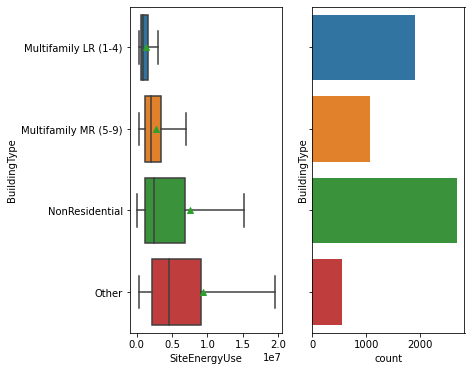

In [1879]:
make_plot("BuildingType", target)

In [1881]:
make_anova(data, target, "BuildingType")

Résultats de l'ANOVA pour les variables SiteEnergyUse et BuildingType:
F: 90.93, p: 0.000
Eta-squared: 0.0422


Dépendance entre BuildingType et SiteEnergyUse_log. Peut-on se s'affranchir de certaines features?

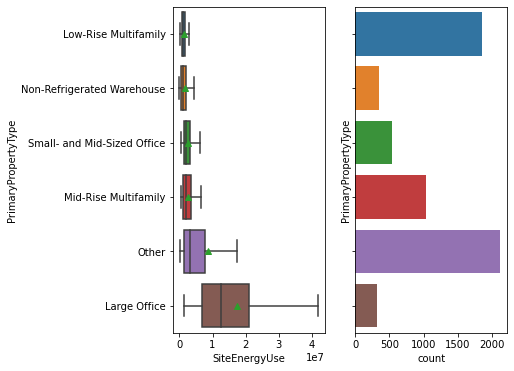

In [1882]:
make_plot("PrimaryPropertyType", target)

In [1886]:
subcat = [
          "Small- and Mid-Sized Office",
          "Mid-Rise Multifamily", 
         ]
make_anova(data, target, "PrimaryPropertyType", subcat=subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et PrimaryPropertyType:
F: 1.04, p: 0.308
Eta-squared: 0.0007


On peut donc s'affranchir de ces catégories.

In [1887]:
def make_broadcat(cat_var, categories, new_name):
    data[cat_var] = data[cat_var].apply(lambda x: new_name if x in categories
                                                               else x)

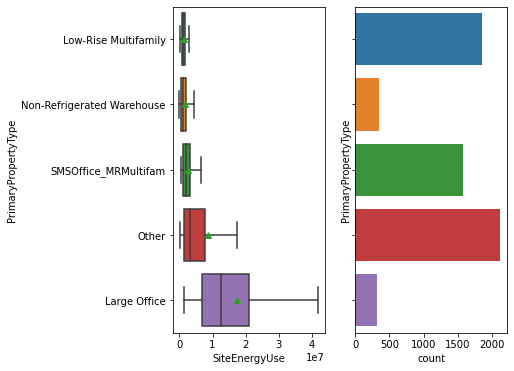

In [1889]:
cat_var = "PrimaryPropertyType"
categories = [
          "Small- and Mid-Sized Office",
          "Mid-Rise Multifamily", 
         ]
make_broadcat(cat_var, categories, "SMSOffice_MRMultifam")

make_plot("PrimaryPropertyType", target)

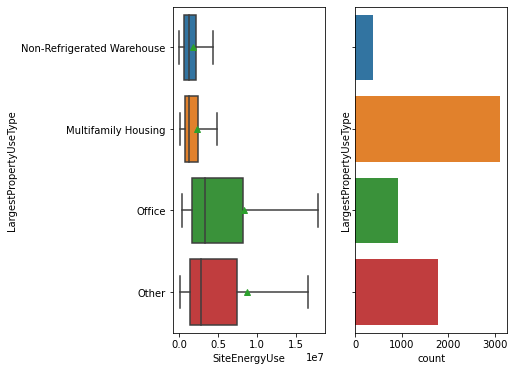

In [1890]:
make_plot("LargestPropertyUseType", target)

In [1893]:
subcat = ["Non-Refrigerated Warehouse", 
          "Multifamily Housing",
         ]
make_anova(data, target, "LargestPropertyUseType", subcat=subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et LargestPropertyUseType:
F: 9.20, p: 0.002
Eta-squared: 0.0026


In [1894]:
subcat = ["Office", 
          "Other",
         ]
make_anova(data, target, "LargestPropertyUseType", subcat=subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et LargestPropertyUseType:
F: 0.27, p: 0.603
Eta-squared: 0.0001


In [ ]:
cat_var = "LargestPropertyUseType"
categories = ["Office", 
          "Other",
         ]
make_broadcat(cat_var, categories, "Other_Office")

In [1896]:
valuecount_df("LargestPropertyUseType")

,nb_items
Multifamily Housing,3117
Other_Office,2703
Non-Refrigerated Warehouse,374


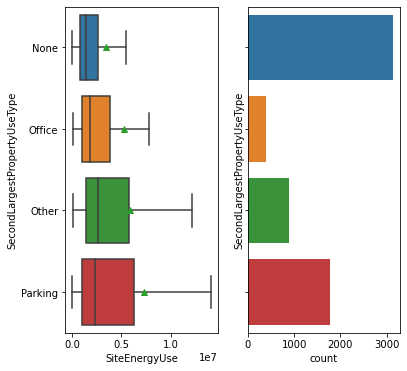

In [1898]:
make_plot("SecondLargestPropertyUseType", target)

In [1899]:
subcat = ["Office",
          "Other"
        ]
make_anova(data, target, "SecondLargestPropertyUseType", subcat=subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et SecondLargestPropertyUseType:
F: 0.30, p: 0.583
Eta-squared: 0.0002


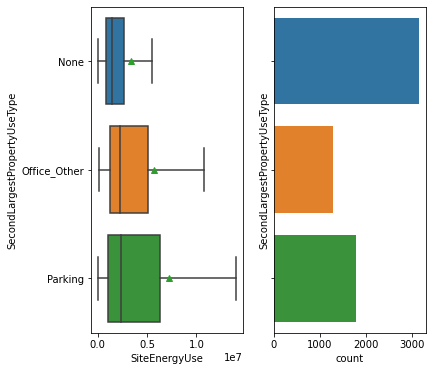

,nb_items
None,3136
Parking,1778
Office_Other,1280


In [1900]:
cat_var = "SecondLargestPropertyUseType"
categories = ["Office",
          "Other"
        ]
make_broadcat(cat_var, categories, "Office_Other")
make_plot("SecondLargestPropertyUseType", target)
valuecount_df("SecondLargestPropertyUseType")

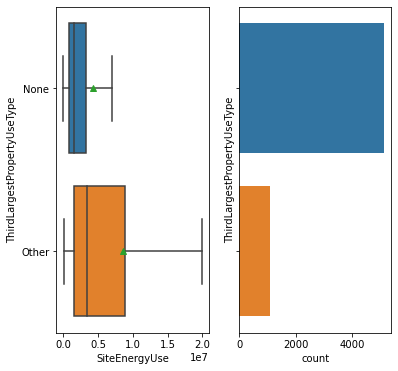

In [1901]:
make_plot("ThirdLargestPropertyUseType", target)

In [1902]:
subcat = ["None",
          "Other"
        ]
make_anova(data, target, "ThirdLargestPropertyUseType", subcat=subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et ThirdLargestPropertyUseType:
F: 75.50, p: 0.000
Eta-squared: 0.0120


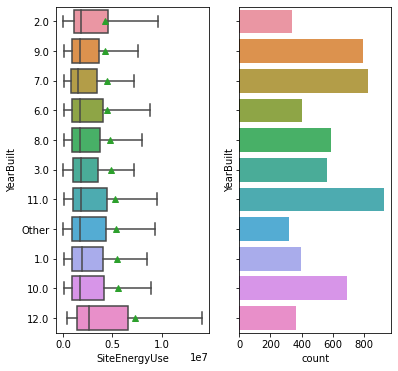

In [1903]:
make_plot("YearBuilt", target)

In [1908]:
make_anova(data, target, "YearBuilt")

Résultats de l'ANOVA pour les variables SiteEnergyUse et YearBuilt:
F: 1.49, p: 0.135
Eta-squared: 0.0024


Pas vraiment d'association entre YEarBuilt et SiteEnergyUse en fin de compte. On pourra l'écarter du modèle

In [1909]:
target = "TotalGHGEmissions"
make_anova(data, target, "YearBuilt")

Résultats de l'ANOVA pour les variables TotalGHGEmissions et YearBuilt:
F: 1.53, p: 0.121
Eta-squared: 0.0025


Idem pour la prévision de TotalGHGEmissions

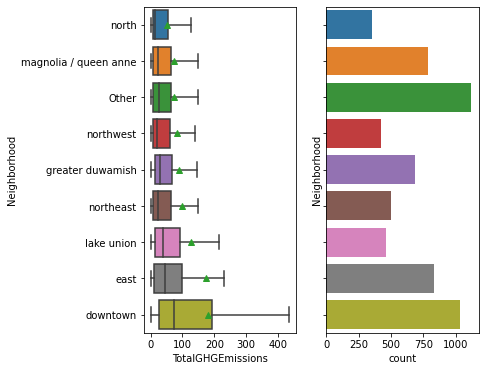

In [1910]:
make_plot("Neighborhood", target)

In [1911]:
make_anova(data, "SiteEnergyUse", "Neighborhood")

Résultats de l'ANOVA pour les variables SiteEnergyUse et Neighborhood:
F: 18.25, p: 0.000
Eta-squared: 0.0231


In [1915]:
subcat = ["magnolia / queen anne", 
          "Other",
         "northwest",
         "greater duwamish",
         "northeast",
        ]
make_anova(data, "SiteEnergyUse", "Neighborhood", subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et Neighborhood:
F: 1.23, p: 0.295
Eta-squared: 0.0014


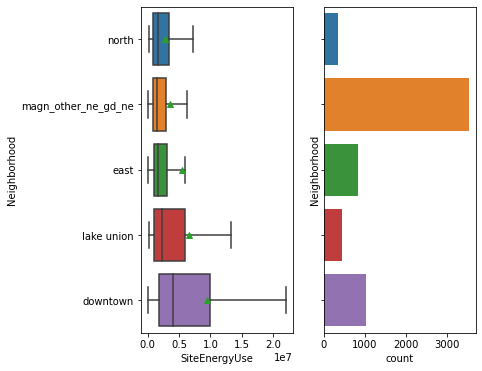

,nb_items
magn_other_ne_gd_ne,3516
downtown,1032
east,831
lake union,459
north,356


In [1916]:
cat_var = "Neighborhood"
categories = ["magnolia / queen anne", 
              "Other",
              "northwest",
              "greater duwamish",
              "northeast"
             ]
make_broadcat(cat_var, categories, "magn_other_ne_gd_ne")
make_plot("Neighborhood", "SiteEnergyUse")
valuecount_df("Neighborhood")

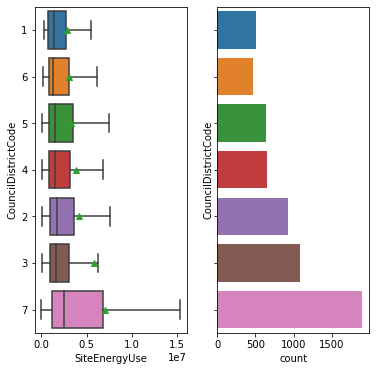

In [1785]:
make_plot("CouncilDistrictCode", target)

In [1921]:
subcat = [1,
          2,
          3, 
          4, 
          5, 
          6,
         ]
make_anova(data, "SiteEnergyUse", "CouncilDistrictCode", subcat=subcat)

Résultats de l'ANOVA pour les variables SiteEnergyUse et CouncilDistrictCode:
F: 0.85, p: 0.358
Eta-squared: 0.0002


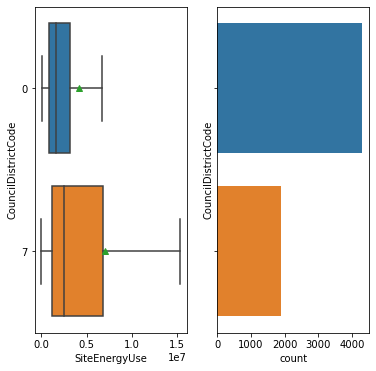

,nb_items
0,4295
7,1899


In [1922]:
cat_var = "CouncilDistrictCode"
categories = [1,
          2,
          3, 
          4, 
          5, 
          6,
         ]
make_broadcat(cat_var, categories, 0)
make_plot("CouncilDistrictCode", "SiteEnergyUse")
valuecount_df("CouncilDistrictCode")

On va maintenant inspecter les corrélations entre les prédicteurs. On définit la fonction contingence qui va permettre d'afficher les tables de contingence, et le résultat de tests du chi2 sur chaque paire.

In [1950]:
from scipy.stats import chi2_contingency

def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    
    
    xi_n = measure.sum().sum()
    table = measure/xi_n
    totx = table.sum(axis=0)
    toty = table.sum(axis=1)
    plt.figure(figsize=(18, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
    chi2, pval, dof, chi2_table = chi2_contingency(c.iloc[:-1, :-1])
    
    #plt.figure(figsize=(18, 6))
    #sns.heatmap(chi2_table, annot=chi2_table, fmt=".0f")
    print("coefficient du chi2: {:.0f}".format(chi2))
    print("p-valeur: {}".format(pval))

**1. PrimaryPropertyType vs LargestPropertyUseType**

coefficient du chi2: 9597
p-valeur: 0.0


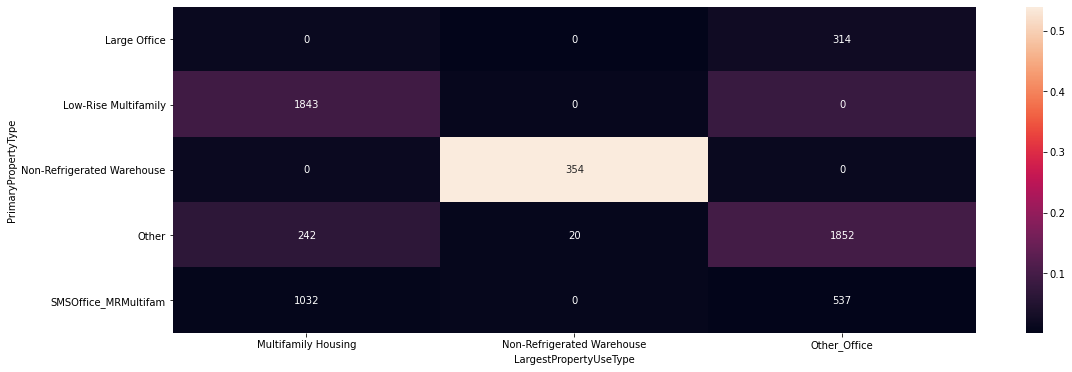

In [1951]:
contingence("PrimaryPropertyType", "LargestPropertyUseType", data)

Les variables PrimaryPropertyType et LargestPropertyUseType sont hautement associées. On va se servir de la table de contingence pour "réorganiser" les modalités de PrimaryPropertytype, et on aura ainsi deux modèles différents, selon la variable qu'on choisira.

1. On commence par intégrer Non-Refrigerated Warehouse dans "Other"

coefficient du chi2: 4128
p-valeur: 0.0


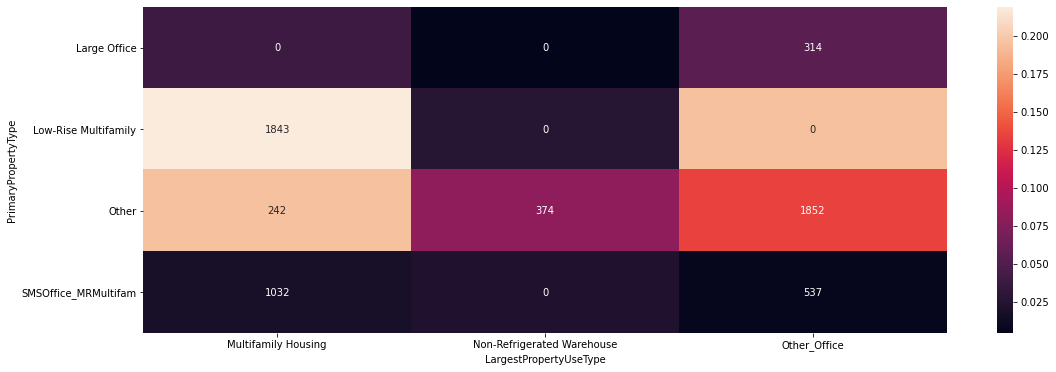

In [1978]:
df = data.copy()
df["PrimaryPropertyType"] = df["PrimaryPropertyType"].apply(lambda x: "Other" if x in "Non-Refrigerated Warehouse"
                                                               else x)
#make_broadcat("PrimaryPropertyType", "Non-Refrigerated Warehouse", )
contingence("PrimaryPropertyType", "LargestPropertyUseType", df)

2. On dispatche les éléments de "Other" entre les autres modalités en fonction de la modalité correspondante dans LargestPropertyUseType

coefficient du chi2: 10877
p-valeur: 0.0


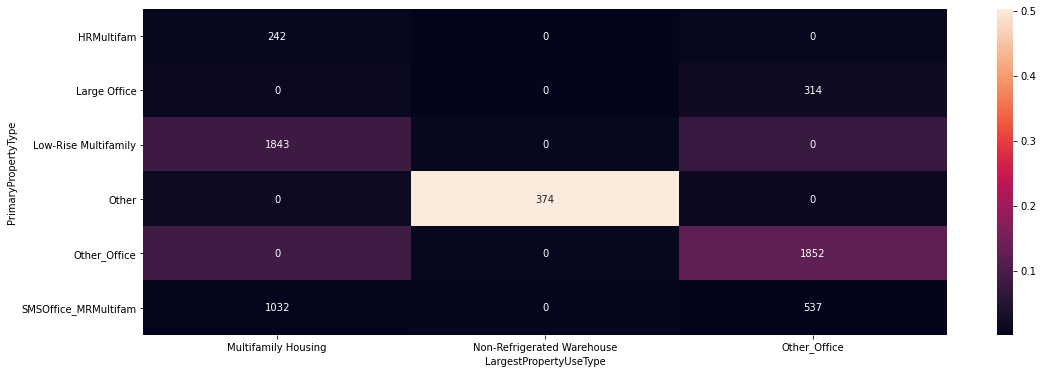

In [1979]:
df["PrimaryPropertyType"] = df[["PrimaryPropertyType", "LargestPropertyUseType"]].apply(lambda x: "HRMultifam" 
                                                            if (x[0]=="Other") and (x[1]=="Multifamily Housing")
                                                            else x[0], axis=1)

df["PrimaryPropertyType"] = df[["PrimaryPropertyType", "LargestPropertyUseType"]].apply(lambda x: "Other_Office" 
                                                            if (x[0]=="Other") and (x[1]=="Other_Office")
                                                            else x[0], axis=1)
#df["PrimaryPropertyType"] = df["PrimaryPropertyType"].apply(lambda x: "Office_MRMultifam" 
#                                                            if x in "SMSOffice_MRMultifam" 
#                                                               else x)

contingence("PrimaryPropertyType", "LargestPropertyUseType", df)

3. Au contraire, on "simplifie" la variable LargestPropertyUseType au maximum. Cela correspondra à deux modèles différents.

In [1992]:
df["LargestPropertyUseType"] = df["LargestPropertyUseType"].apply(lambda x: "Other_Office" if x in "Non-Refrigerated Warehouse"
                                                               else x)

**2. Autres associations**

coefficient du chi2: 42
p-valeur: 8.712739045818257e-06


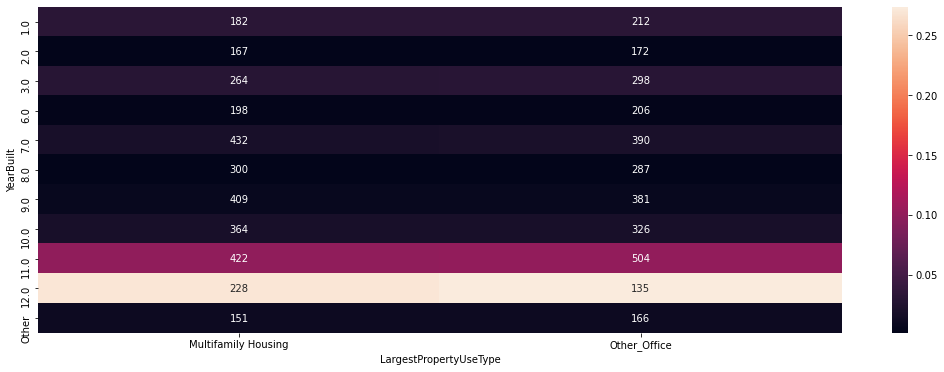

In [1990]:
contingence("YearBuilt", "LargestPropertyUseType", df)

Dans le modèle utilisant LargestPropertyUseType, on pourra grouper ou non les modalités de YearBuilt.

coefficient du chi2: 156
p-valeur: 8.190987433541047e-13


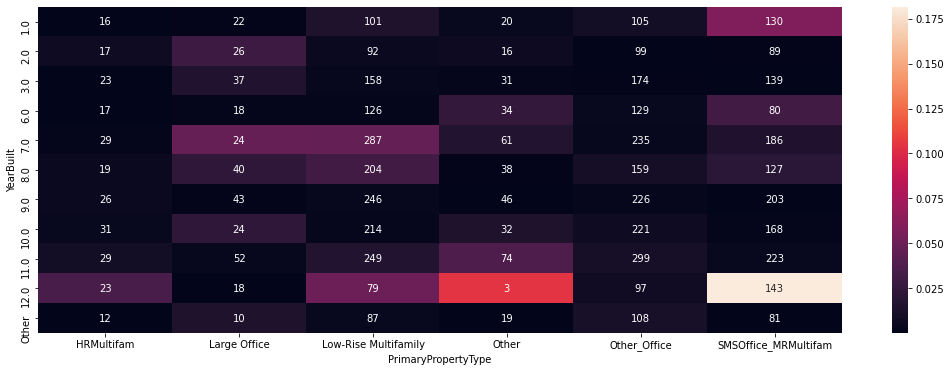

In [1991]:
contingence("YearBuilt", "PrimaryPropertyType", df)

coefficient du chi2: 295
p-valeur: 1.0331918370184913e-62


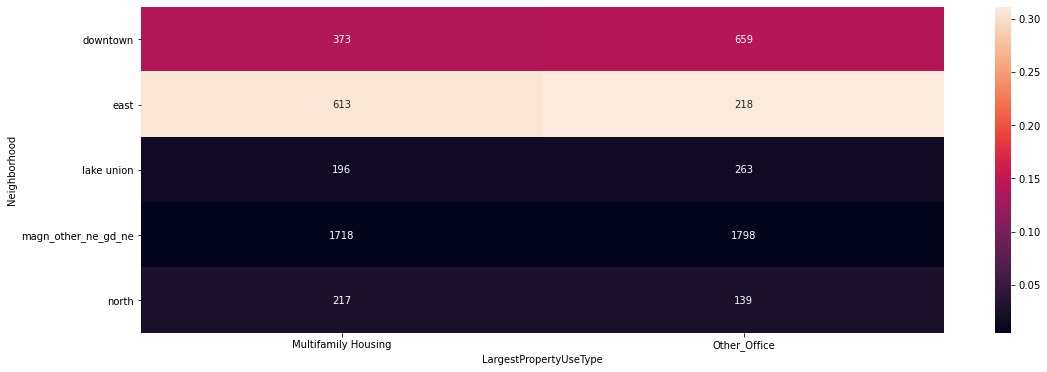

In [1993]:
contingence("Neighborhood", "LargestPropertyUseType", df)

De meme, on pourra grouper les modalités de Neighborhood.

coefficient du chi2: 1391
p-valeur: 1.1276486821576693e-282


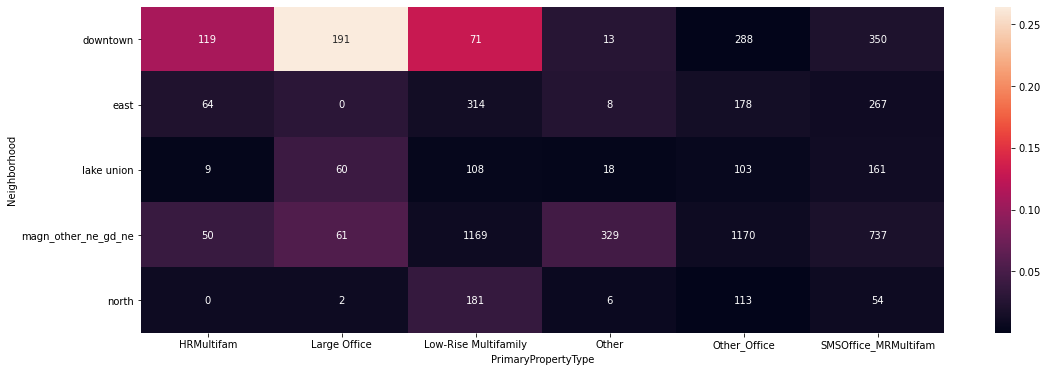

In [1985]:
contingence("Neighborhood", "PrimaryPropertyType", df)

coefficient du chi2: 2
p-valeur: 0.12101691595225855


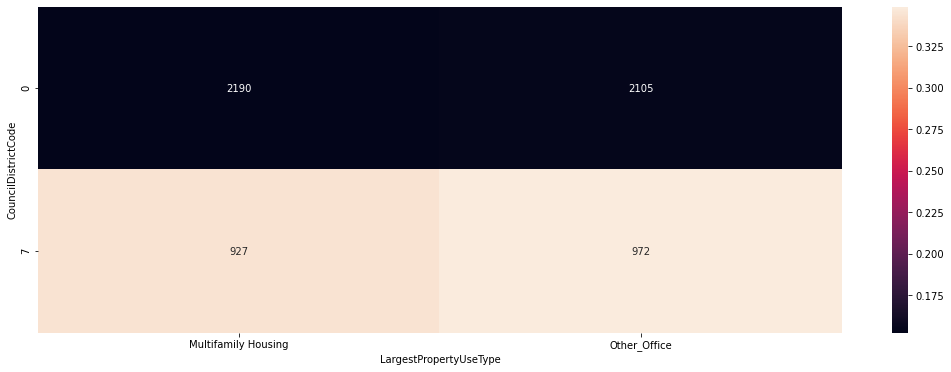

In [1994]:
contingence("CouncilDistrictCode", "LargestPropertyUseType", df)

In [1995]:
data.to_csv("./modele1.csv", index_label=False)
df.to_csv("./modele2.csv", index_label=False)

# III Modèles
## III.1 Régressions Linéaires

In [464]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import set_config

set_config(display='diagram')

Chargement des modèles

In [433]:
modele1 = pd.read_csv("./modele1.csv")
modele2 = pd.read_csv("./modele2.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6213 entries, 0 to 6212
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6213 non-null   int64  
 1   DataYear                         6213 non-null   int64  
 2   BuildingType                     6213 non-null   object 
 3   PrimaryPropertyType              6213 non-null   object 
 4   Neighborhood                     6213 non-null   object 
 5   YearBuilt                        6213 non-null   int64  
 6   NumberofBuildings                6213 non-null   float64
 7   NumberofFloors                   6213 non-null   float64
 8   PropertyGFATotal                 6213 non-null   int64  
 9   PropertyGFAParking               6213 non-null   int64  
 10  PropertyGFABuilding(s)           6213 non-null   int64  
 11  ListOfAllPropertyUseTypes        6213 non-null   object 
 12  LargestPropertyUseTy

In [601]:
df = data.drop(columns=["OSEBuildingID", 
                        "ENERGYSTARScore",
                        "PropertyGFATotal",
                        "PropertyGFABuilding(s)", 
                        "ListOfAllPropertyUseTypes"])

# Sélection des cibles
targets = ["SiteEnergyUse(kBtu)",
           "SiteEnergyUse_log",
           "TotalGHGEmissions", 
           "TotalGHGEmissions_log"]

# retrait des colonnes liées à la consommation d'énergie
energy_type = ["SiteEnergyUseWN(kBtu)", 
               "SteamUse(kBtu)",
               "Electricity(kBtu)",
               "NaturalGas(kBtu)"]

# Sélection des variables
features = [col for col in df.columns if (col not in targets) and (col not in energy_type)]

# Séparation des variables en types "category" et "float64"
df[["NumberofBuildings", "NumberofFloors"]] = df[["NumberofBuildings", 
                                                  "NumberofFloors"]].astype("int64")
df[["PropertyGFAParking",
    #"PropertyGFABuilding(s)"
   ]] = \
df[["PropertyGFAParking",
    #"PropertyGFABuilding(s)"
   ]].astype("float64")
cat_cols = df.dtypes[(df.dtypes=="int64") | (df.dtypes=="object")].index
df[cat_cols] = df[cat_cols].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6213 entries, 0 to 6212
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   DataYear                         6213 non-null   category
 1   BuildingType                     6213 non-null   category
 2   PrimaryPropertyType              6213 non-null   category
 3   Neighborhood                     6213 non-null   category
 4   YearBuilt                        6213 non-null   category
 5   NumberofBuildings                6213 non-null   category
 6   NumberofFloors                   6213 non-null   category
 7   PropertyGFAParking               6213 non-null   float64 
 8   LargestPropertyUseType           6213 non-null   category
 9   LargestPropertyUseTypeGFA        6213 non-null   float64 
 10  SecondLargestPropertyUseType     6213 non-null   category
 11  SecondLargestPropertyUseTypeGFA  6213 non-null   float64 
 12  ThirdL

In [602]:
df.head()

,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse_log,TotalGHGEmissions_log
0,2015,NonResidential,Hotel,DOWNTOWN,1927,1,12,0.0,Hotel,88434.0,...,None,0.0,6981428.0,7097539.0,2023032.0,3686160.0,1272388.0,249.43,6.843944,2.396949
1,2015,NonResidential,Hotel,DOWNTOWN,1996,1,11,15064.0,Hotel,83880.0,...,Restaurant,4622.0,8354235.0,8765788.0,0.0,3905411.0,4448985.0,263.51,6.921907,2.420797
2,2015,NonResidential,Hotel,DOWNTOWN,1969,1,41,0.0,Hotel,757243.0,...,Swimming Pool,0.0,73130656.0,75506272.0,19660404.0,49762435.0,3709900.0,2061.48,7.864099,3.314179
3,2015,NonResidential,Hotel,DOWNTOWN,1980,1,18,12460.0,Hotel,123445.0,...,Swimming Pool,0.0,14829099.0,15078243.0,0.0,6066245.0,8763105.0,507.70,7.171115,2.705607
4,2015,Nonresidential COS,Other,DOWNTOWN,1999,1,2,37198.0,Police Station,88830.0,...,None,0.0,12051984.0,13045258.0,0.0,7271004.0,4781283.0,304.62,7.081059,2.483758


## III.1 Régression linéaire simple avec toutes les variables

In [603]:
def print_lr(target, features, df):
    
    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selector(dtype_exclude="category")),
            ('cat', categorical_transformer, selector(dtype_include="category"))
        ])
    
    # Append regressor to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])
    
    X = df[features]
    y = df[target]
    
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    #scores = cross_val_score(reg, X, y, cv=kf)
    cv_results = pd.DataFrame(cross_validate(reg, X, y, cv=kf,
                            scoring=('r2',
                                     #'neg_mean_squared_log_error'
                                    ),
                            return_train_score=True)).sort_values(by="test_r2", ascending=False)
    
    # remplace les valeurs de neg_mean_squared_error, par leurs opposées
    
    #for t in ["train", "test"]:
    #    cv_results[t+"_neg_mean_squared_log_error"] = -cv_results[t+"_neg_mean_squared_log_error"]
    moyenne = pd.DataFrame(data=cv_results.to_numpy().mean(axis=0).reshape(1, -1), 
                           columns=cv_results.columns, 
                           index=["moyenne"])
    cv_results = pd.concat([cv_results, moyenne])
    
    #print("Scores: ", scores)
    #print("Score moyen: {:.2f}".format(np.mean(scores)))
    
    return cv_results

In [604]:
print_lr("SiteEnergyUse_log", features, df)

,fit_time,score_time,test_r2,train_r2
3,0.553483,0.027545,0.676639,0.734437
0,0.496030,0.021723,0.652175,0.734978
2,0.523201,0.025842,0.643335,0.730671
1,0.443324,0.021382,0.626980,0.737483
4,0.649845,0.020296,-0.422266,0.740140
moyenne,0.533177,0.023357,0.435372,0.735542


In [605]:
print_lr("SiteEnergyUse(kBtu)", features, df)

,fit_time,score_time,test_r2,train_r2
4,0.390856,0.020779,0.829692,0.818484
3,0.444523,0.040924,0.758474,0.881976
0,0.471113,0.020421,0.655954,0.879055
2,0.561091,0.022339,0.620502,0.894922
1,0.486700,0.037783,0.438595,0.888729
moyenne,0.470857,0.028449,0.660643,0.872633


## III.3 Ridge

In [476]:
def print_modelresult(target, features, df, params, model_gs, score, axis_scale="log", plot_param="alpha"):


    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selector(dtype_exclude="category")),
            ('cat', categorical_transformer, selector(dtype_include="category"))
        ])
    
    # Append regressor to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', model_gs)])
    
    # Séparation prédicteurs - cible
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Créer une regression Ridge avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance en généralisation du meilleur modèle sur le set de validation
    y_pred = regr.predict(X_test)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    # Résultats de la validation croisée
    cv_results = pd.DataFrame(regr.cv_results_)
        
    cv_results = cv_results.sort_values("mean_test_r2", ascending=False)
    
    param_keys = ["param_"+k for k in param_grid.keys()]
    param_cols = []
    for sample in ("train", "test"):
        for i in range(len(score)):
            for s in ("mean", "std"):
                param_cols.append("{}_{}_{}".format(s, sample, score[i]))
        
        # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
        try:
            cv_results["mean_{}_{}".format(sample, score[1])] *= -1
        except:
            pass
        
    param_cols += param_keys
    param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]
    
    # Affiche les scores sur les jeu d'entrainement et de test
    d = cv_results.set_index("param_regressor__{}".format(plot_param))
    cols = []
    for t in ("train", "test"):
        for s in score: 
            cols.append("mean_{}_{}".format(t, s))
            
    sns.lineplot(data=d[cols])
    plt.xscale(axis_scale)
    plt.show()
    
    return cv_results[param_cols], cv_results.iloc[0]
    

In [1237]:
def print_reg_path(model, **hyperparams):    
    '''Calcule et affiche le chemin de régularisation''' 
        
    models = {Ridge: (Ridge(hyperparams), "alpha"),
              Lasso: (Lasso(hyperparams), "alpha"),
              ElasticNet: (ElasticNet(hyperparams), ("alpha", "l1_ratio")),
              KNeighborsRegressor: (KNeighborsRegressor, "n_neighbors")}
    
    print(hyparams)
    coefs = []
    for k, v in hyperparams.items():
        reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', model_rp(alpha=h, l1_ratio=0.1, tol=0.001, max_iter=1e4))])
        #ridge = Ridge(alpha=a, fit_intercept=False)
        reg.fit(X_train, y_train)
        coefs.append(reg.named_steps['regressor'].coef_)
    
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    #ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coefficients as a function of the regularization')
    plt.axis('tight')
    plt.show()

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 12.91549665014884}

Sur le jeu de test : 0.658


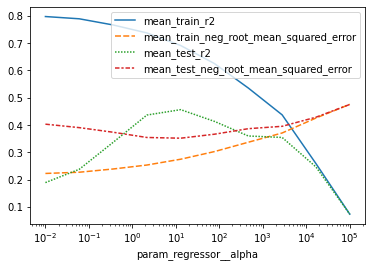

In [477]:
# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-2, 5, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Ridge()

# fit et affichage des résultats
log_ridgeresults, log_ridgebestresult = print_modelresult("SiteEnergyUse_log",
                                                            features,
                                                            df,
                                                            params,
                                                            model,
                                                            score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.0027825594022071257}

Sur le jeu de test : 0.617


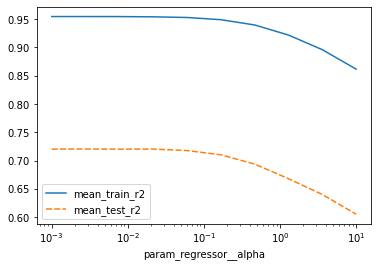

In [479]:
# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-3, 1, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 
         #'neg_mean_squared_log_error'
        )

# modèle
model = Ridge()

# fit et affichage des résultats
ridge_results, ridge_bestresult = print_modelresult("SiteEnergyUse(kBtu)",
                                                    features,
                                                    df,
                                                    params,
                                                    model,
                                                    score)

## III.4 Lasso

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.00046415888336127773}

Sur le jeu de test : 0.654


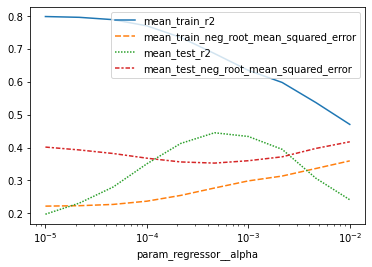

In [482]:
# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-5, -2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Lasso(max_iter=1e4)

# fit et affichage des résultats
log_lassoresults, log_lassobestresult = print_modelresult("SiteEnergyUse_log",
                                        features,
                                        df,
                                        params,
                                        model,
                                        score)

## III.5 ElasticNet

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.0004832930238571752, 'regressor__l1_ratio': 0.1}

Sur le jeu de test : 0.617


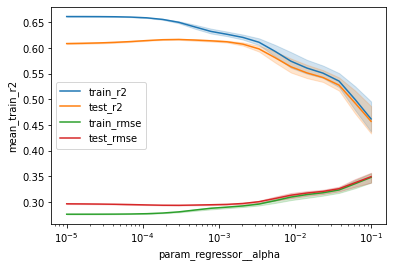

,mean_train_r2,std_train_r2,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,param_regressor__alpha,param_regressor__l1_ratio
56,0.651844,0.004177,0.280425,0.001720,0.619904,0.023856,0.292710,0.009428,0.000483293,0.1
63,0.647242,0.004212,0.282272,0.001741,0.619465,0.021818,0.292903,0.008684,0.00078476,0.1
49,0.655563,0.004100,0.278923,0.001683,0.619447,0.026097,0.292858,0.010251,0.000297635,0.1
42,0.658204,0.004060,0.277852,0.001662,0.618401,0.028186,0.293233,0.011017,0.000183298,0.1
70,0.642103,0.004219,0.284321,0.001762,0.618169,0.020209,0.293419,0.008066,0.00127427,0.1
...,...,...,...,...,...,...,...,...,...,...
135,0.455222,0.008547,0.350777,0.002450,0.450221,0.021103,0.352095,0.004299,0.1,0.7
136,0.440008,0.008025,0.355644,0.002404,0.436481,0.021606,0.356465,0.003976,0.1,0.9
137,0.436206,0.008071,0.356850,0.002419,0.432760,0.021702,0.357640,0.003919,0.1,0.95
138,0.433093,0.008076,0.357833,0.002412,0.429661,0.021787,0.358615,0.003892,0.1,0.99


In [1178]:
# Valeurs possibles de(s) (l')hyperparamètre(s)
params = {"alpha" : np.logspace(-5, -1, 20), "l1_ratio":[.1, .5, .7, .9, .95, .99, 1]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = ElasticNet(tol=0.001, max_iter=1e5)

# fit et affichage des résultats
print_modelresult("SiteEnergyUse_log", data, params, model, score)

# IV kNN

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 3}

Sur le jeu de test : 0.755


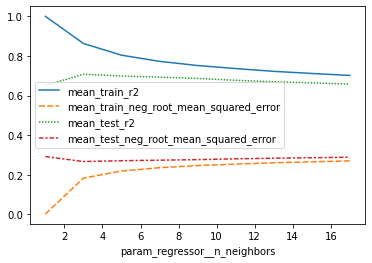

In [483]:
from sklearn.neighbors import KNeighborsRegressor

# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = KNeighborsRegressor()

# fit et affichage des résultats
log_knnresults, log_knnbestresult = print_modelresult("SiteEnergyUse_log",
                                                        features,
                                                        df,
                                                        params,
                                                        model,
                                                        score,
                                                        axis_scale="linear",
                                                        plot_param="n_neighbors")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 1}

Sur le jeu de test : 0.469


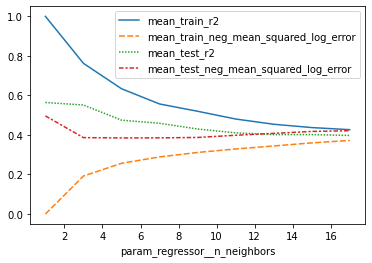

In [364]:
# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSLE 
score = ('r2', 
         'neg_mean_squared_log_error')

# modèle
model = KNeighborsRegressor()

# affichage des résultats
knn_results, knn_bestresult = print_modelresult("SiteEnergyUse(kBtu)",
                                                features,
                                                df,
                                                params,
                                                model,
                                                score,
                                                axis_scale="linear",
                                                plot_param="n_neighbors")

# V SVM

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__C': 5.994842503189409}

Sur le jeu de test : 0.614


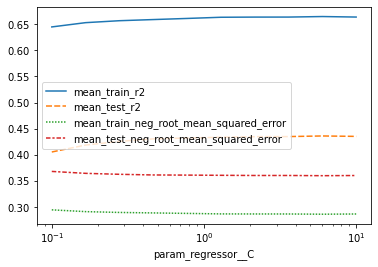

In [212]:
from sklearn.svm import LinearSVR

# Valeurs possibles du paramètre C
params = {"C" : np.logspace(-2, 2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = LinearSVR(tol=1e-3, max_iter=1e5, dual=False, loss="squared_epsilon_insensitive")

# fit et affichage des résultats
log_svmresults, log_svm_bestresult = print_modelresult("SiteEnergyUse_log",
                                                       features,
                                                       df,
                                                       params,
                                                       model,
                                                       score,
                                                       plot_param="C")

# VI Modèles non-linéaires

## VI.1 SVM à noyau

In [1953]:
from sklearn.svm import SVR
from sklearn import metrics

def print_SVR(quant_var, qualit_var, target, df, C, gamma, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'C': C, "gamma":gamma}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    SVR(tol=1e-3, max_iter=1e5, kernel="rbf"), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    # Calcul de la matrice de Gram
    kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=regr.best_params_["gamma"])
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    return kmatrix

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__C': 6.30957344480193, 'regressor__gamma': 0.046415888336127774}

Sur le jeu de test : 0.818


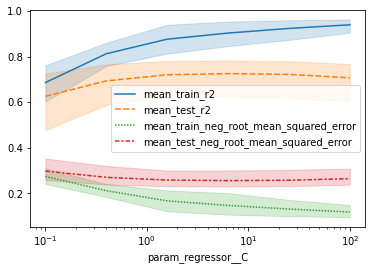

In [213]:
from sklearn.svm import SVR

# Valeurs possibles des hyperparamètres
params = {"C" : np.logspace(-1, 2, 6), "gamma":np.logspace(-2, 0, 4)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model=SVR(tol=1e-3, max_iter=1e5, kernel="rbf")

# fit et affichage des résultats
log_kerlsvmresults, log_kernelsvm_bestresult = print_modelresult("SiteEnergyUse_log",
                                                                 features,
                                                                 df,
                                                                 params,
                                                                 model,
                                                                 score,
                                                                 plot_param="C")

#kmatrix = print_SVR(quant_var, qualit_var, "SiteEnergyUse_log", d2015, C, gamma, score)
#kmatrix100 = kmatrix[:100, :100]

#sns.heatmap(kmatrix)
#plt.show()

# VII Méthodes ensemblistes

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

## VII.1 Forêts aléatoires

Premier essai avec l'algorithme RandomForestRegressor sur les mêmes features que précédemment et un nombre d'estimateurs à 100. Le but est à la fois d'obtenir une première estimation par cet algorithme et une mesure des feature_importances dans le but d'optimiser le modèle.

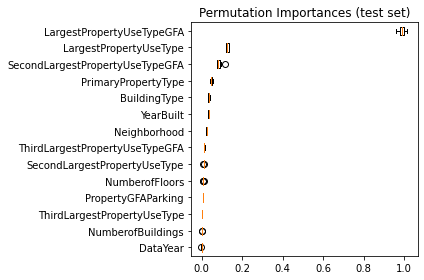

In [606]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

target = "SiteEnergyUse_log"

# One-hot encoding of categorical variable
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Standard scaling of numerical features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('cat', categorical_transformer, selector(dtype_include="category"))
    ])

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=100, oob_score=True))])

# Séparation prédicteurs - cible
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)

reg.fit(X_train, y_train)
result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [607]:
y_pred = reg.predict(X_test)
print("R2 score: {}".format(r2_score(y_test, y_pred)))

R2 score: 0.8612278220495744


In [560]:
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(reg.named_steps["regressor"], threshold=0.001, prefit=True)
X_train2 = select.transform(preprocessor.transform(X_train))
X_test2 = select.transform(preprocessor.transform(X_test))

reg.named_steps["regressor"].fit(X_train2, y_train)

pred2 = reg.named_steps["regressor"].predict(X_test2)
y_pred2 = reg.named_steps["regressor"].predict(X_test2)
print("R2 score: {}".format(r2_score(y_test, y_pred2)))

R2 score: 0.8564526147330072


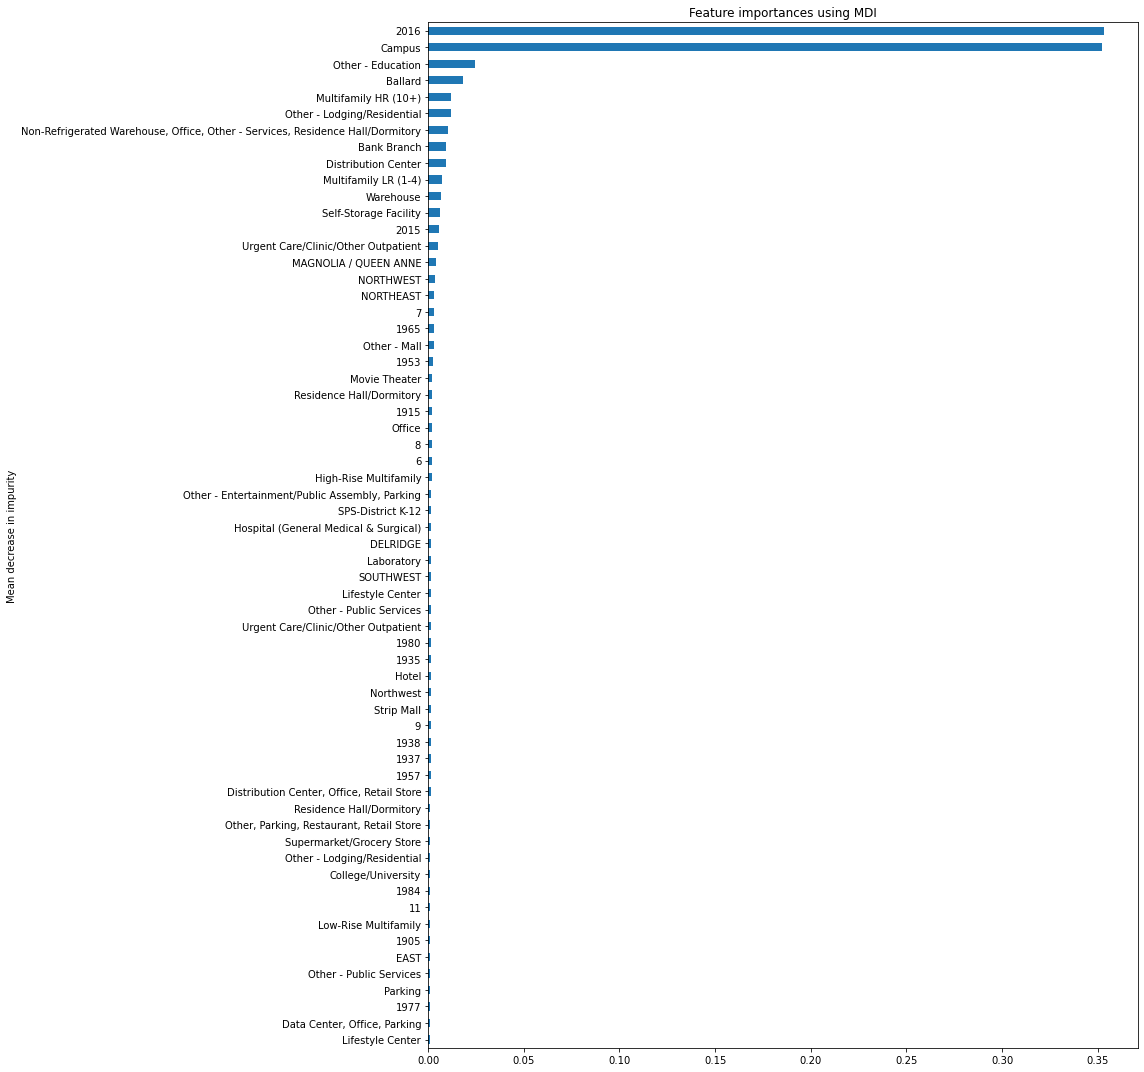

In [563]:
feature_names2 = feature_names[importances>=1e-3]
importances2 = importances[importances>=1e-3]


forest_importances2 = pd.Series(data=importances2, index=feature_names2)

fig, ax = plt.subplots(figsize=(16, 15))
forest_importances2.sort_values().plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Deuxième essain cette fois avec normalisation des features, et recherche du meilleur nombre d'estimateur;

In [73]:
from sklearn.ensemble import RandomForestRegressor

def print_RFR(quant_var, qualit_var, target, df, n_estimators, score):
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'n_estimators': n_estimators}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    RandomForestRegressor(oob_score=True), # régresseur basé sur l'alogorithme RandomForest
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    print("params: ")
    print(regr.get_params())

In [582]:
from sklearn.ensemble import RandomForestRegressor

# Valeurs possibles du nombre d'arbres
params = {"n_estimators" : [100, 200, 500, 1000]}

# Choisir un score à optimiser, ici le R2
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model=RandomForestRegressor(oob_score=True)

# fit et affichage des résultats
#log_randomforestresults, log_randomforestbestresult = print_modelresult("SiteEnergyUse_log",
#                                    features,
#                                    df, 
#                                    params, 
#                                    model, 
#                                    score, 
#                                    plot_param="n_estimators",
#                                    axis_scale="linear")

# One-hot encoding of categorical variable
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Standard scaling of numerical features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('cat', categorical_transformer, selector(dtype_include="category"))
    ])

# Séparation prédicteurs - cible
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

# Nested cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)

# Hyperparamètre à optimiser
param_grid = {}
for key, values in params.items():
    param_grid["regressor__"+key] = values
    
    
# Créer une regression Ridge avec sélection d'hyperparamètre par validation croisée
regr = GridSearchCV(
model,            # modèle
param_grid,     # hyperparamètres à tester
cv=inner_cv,    # nombre de folds de validation croisée
scoring=score,   # score à optimiser
return_train_score=True,
refit='r2',
)



X_train = preprocessor.fit_transform(X_train)[feature_names2]

# Optimiser cet estimateur sur le jeu d'entraînement
regr.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)

X_test = preprocessor.transform(X_test)[feature_names2]

# Performance en généralisation du meilleur modèle sur le set de validation
y_pred = regr.predict(X_test)
print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

# Résultats de la validation croisée
cv_results = pd.DataFrame(regr.cv_results_)
    
cv_results = cv_results.sort_values("mean_test_r2", ascending=False)

param_keys = ["param_"+k for k in param_grid.keys()]
param_cols = []
for sample in ("train", "test"):
    for i in range(len(score)):
        for s in ("mean", "std"):
            param_cols.append("{}_{}_{}".format(s, sample, score[i]))
    
    # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
    try:
        cv_results["mean_{}_{}".format(sample, score[1])] *= -1
    except:
        pass
    
param_cols += param_keys
param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]

# Affiche les scores sur les jeu d'entrainement et de test
d = cv_results.set_index("param_regressor__{}".format(plot_param))
cols = []
for t in ("train", "test"):
    for s in score: 
        cols.append("mean_{}_{}".format(t, s))

log_randomforestresults, log_randomforestbestresult = cv_results[param_cols], cv_results.iloc[0]


sns.lineplot(data=d[cols])
plt.xscale(axis_scale)
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

In [576]:
X_train = preprocessor.fit_transform(X_train)

In [581]:
X_train.toarray()

array([[-2.76118187e-01, -2.73483322e-01, -2.38679341e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.76118187e-01, -3.13765483e-01, -2.87209549e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.76118187e-01, -3.64488080e-01, -3.78496973e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.76118187e-01, -2.76749866e-01, -2.49579174e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.76118187e-01, -3.17643072e-02, -5.24877915e-04, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.37503819e-01, -3.71234769e-01, -3.45633289e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [217]:
_

,mean_train_r2,std_train_r2,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,param_regressor__n_estimators,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,0.978309,0.000630,0.072782,0.001710,0.830983,0.016695,0.203075,0.017532,1000,158.283766,5.898714,0.511629,0.006046
1,0.977713,0.000599,0.073777,0.001634,0.830851,0.016781,0.203154,0.017607,200,31.377143,0.990068,0.114332,0.003371
2,0.978039,0.000618,0.073234,0.001676,0.830725,0.016846,0.203232,0.017645,500,76.191120,0.398310,0.261309,0.001971
0,0.977006,0.000758,0.074935,0.001860,0.828897,0.016923,0.204320,0.017638,100,16.460281,1.503900,0.064748,0.000751


## VII.2 GradientBoostingRegressor

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
def print_GBR(quant_var, qualit_var, target, df, n_estimators, score):
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'n_estimators': n_estimators}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    GradientBoostingRegressor(), # régresseur basé sur l'alogorithme RandomForest
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_estimators': 4000}

Sur le jeu de test : 0.859


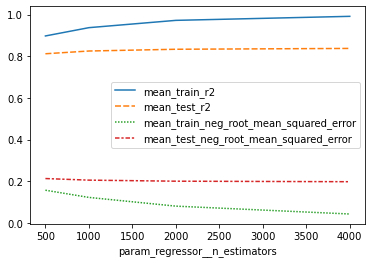

In [215]:
from sklearn.ensemble import GradientBoostingRegressor

# Valeurs possibles du nombre d'arbres
params = {"n_estimators": [500, 1000, 2000, 4000]}

# Choisir un score à optimiser, et/ou une erreur à minimiser ici le R2 et le RMSE
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model=GradientBoostingRegressor()

# fit et affichage des résultats
grboost, gradientboosting = print_modelresult("SiteEnergyUse_log", 
                                    df, 
                                    params, 
                                    model, 
                                    score, 
                                    plot_param="n_estimators",
                                    axis_scale="linear")

In [216]:
grboost

,mean_train_r2,std_train_r2,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,param_regressor__n_estimators,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,0.992206,0.000692,0.043575,0.001825,0.838226,0.018320,0.198571,0.017628,4000,35.808777,1.589657,0.605534,0.008367
2,0.972886,0.001475,0.081349,0.002491,0.834206,0.016145,0.201052,0.016221,2000,17.216456,0.100806,0.118779,0.002266
1,0.937859,0.001412,0.123187,0.002194,0.825803,0.011561,0.206129,0.013707,1000,8.613889,0.100701,0.062508,0.002127
0,0.898064,0.002707,0.157758,0.002173,0.812619,0.011593,0.213771,0.013501,500,4.364814,0.143104,0.038047,0.001722


# VIII Choix du modèle

In [1278]:
index = ["mean_test_r2", "mean_train_r2","mean_test_neg_root_mean_squared_error", "mean_fit_time"]
df = {"Ridge":ridge[index], 
      "Lasso":lasso[index],
      "kNN":knn[index],
      "SVM":svm[index], "SVM Non-linéaire": kernelsvm[index], "randomforest":randomforest[index], 
      "gradient boosting":gradientboosting[index]}
results = pd.DataFrame(data=df)
results

,Ridge,Lasso,kNN,SVM,SVM Non-linéaire,randomforest,gradient boosting
mean_test_r2,0.620365,0.615914,0.698317,0.619368,0.762717,0.826424,0.820197
mean_train_r2,0.648884,0.652793,0.801355,0.646881,0.808213,0.976762,0.995316
mean_test_neg_root_mean_squared_error,0.292555,0.294196,0.260785,0.29291,0.23129,0.197891,0.201305
mean_fit_time,0.0702611,0.156904,0.0310595,0.0415668,0.964753,38.8878,20.9807


# Annexes

In [437]:
# On regroupe TotalGHGEmissions en 10 catégories
deciles = data["TotalGHGEmissions"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# On groupe TotalGHGEmissions en 10 catégories
bins = deciles[4:-1].to_numpy()
cat_TotalGHG = np.digitize(data.TotalGHGEmissions, bins)

# Création d'une Series pour pouvoir concatener
cat_TotalGHG = pd.Series(data=cat_TotalGHG, name="cat_TotalGHG", index=range(0, cat_TotalGHG.shape[0]))

### Latitude, Longitude

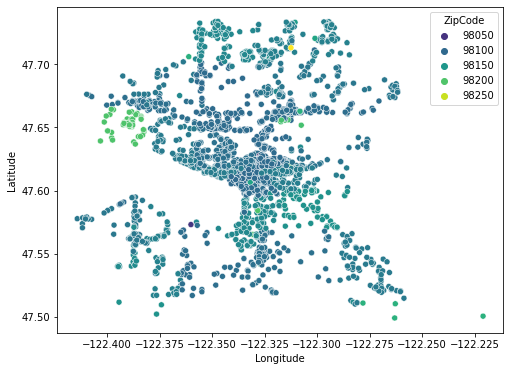

In [945]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Longitude', y="Latitude", data=data[data.ZipCode.notna()], hue="ZipCode", palette="viridis")
plt.show()

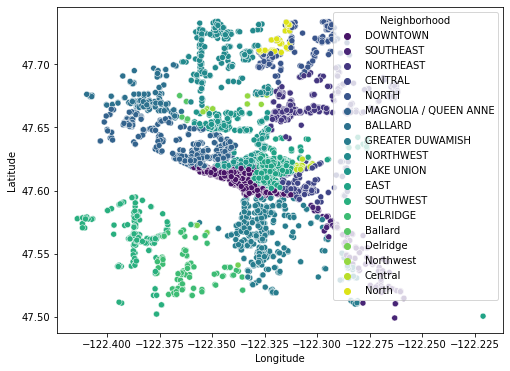

In [446]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Longitude", y='Latitude', data=data, hue="Neighborhood", palette="viridis")
plt.show()